In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 4

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Load normalisers
normaliser = load('./normalisers/x_normaliser.joblib')
y_normaliser = load('./normalisers/y_normaliser.joblib')

In [8]:
# Normalise data
train_norm = normaliser.transform(train)
test_norm = normaliser.transform(test)

##### Now I get indexes for chunks from 4 in 4 days

In [9]:
index = []

for i in range(days):
    index.append(np.arange(i,len(train),days))

In [10]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [11]:
# Normalised train chunks
X_train = np.array([train_norm[ix].copy() for ix in ordered_index])
Y_train = np.array([train_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
Y_train = np.expand_dims(Y_train, -1)

In [12]:
# Delete those sequences that doesn't have a -th day in the results
X_train = X_train[:Y_train.shape[0]]

##### Same for test

In [13]:
index = []

for i in range(days):
    index.append(np.arange(i,len(test),days))

In [14]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [15]:
# Normalised train chunks
X_test = np.array([test_norm[ix].copy() for ix in ordered_index])
Y_test = np.array([test_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
Y_test = np.expand_dims(Y_test, -1)

In [16]:
# Delete those sequences that doesn't have a -th day in the results
X_test = X_test[:Y_test.shape[0]]

# Model selection

##### Model constructor

In [17]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [18]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [19]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [20]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 1s 340us/step - loss: 0.0181 - val_loss: 0.0023
Epoch 2/24
3891/3891 [==============================] - 1s 216us/step - loss: 0.0136 - val_loss: 0.0228
Epoch 3/24
3891/3891 [==============================] - 1s 213us/step - loss: 0.0203 - val_loss: 0.0234
Epoch 4/24
3891/3891 [==============================] - 1s 213us/step - loss: 0.0479 - val_loss: 0.0047
Epoch 5/24
3891/3891 [==============================] - 1s 215us/step - loss: 0.0180 - val_loss: 9.3090e-04
Epoch 6/24
3891/3891 [==============================] - 1s 217us/step - loss: 0.0207 - val_loss: 0.0067
Epoch 7/24
3891/3891 [==============================] - 1s 212us/step - loss: 0.0038 - val_loss: 0.0049
Epoch 8/24
3891/3891 [==============================] - 1s 214us/step - loss: 0.0022 -

Epoch 24/24
3891/3891 [==============================] - 1s 255us/step - loss: nan - val_loss: nan
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 1s 318us/step - loss: 0.0774 - val_loss: 0.0274
Epoch 2/24
3891/3891 [==============================] - 1s 167us/step - loss: 0.0108 - val_loss: 0.0128
Epoch 3/24
3891/3891 [==============================] - 1s 172us/step - loss: 0.0060 - val_loss: 0.0033
Epoch 4/24
3891/3891 [==============================] - 1s 163us/step - loss: 0.0054 - val_loss: 0.0023
Epoch 5/24
3891/3891 [==============================] - 1s 154us/step - loss: 0.0038 - val_loss: 0.0023
Epoch 6/24
3891/3891 [==============================] - 1s 161us/step - loss: 0.0034 - val_loss: 0.0010
Epoch 7/24
3891/3891 [==============================] - 1s 155us/step - loss: 0.0031 - val_loss: 0.0020
Epoch 8/24
3891/3891 [==============================] - 1s 159us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 9/24
3891/3891 [

3891/3891 [==============================] - 2s 395us/step - loss: 0.0166 - val_loss: 0.0040
Epoch 5/24
3891/3891 [==============================] - 2s 390us/step - loss: 0.0123 - val_loss: 0.0027
Epoch 6/24
3891/3891 [==============================] - 2s 387us/step - loss: 0.0100 - val_loss: 0.0025
Epoch 7/24
3891/3891 [==============================] - 1s 376us/step - loss: 0.0086 - val_loss: 0.0025
Epoch 8/24
3891/3891 [==============================] - 1s 380us/step - loss: 0.0077 - val_loss: 0.0025
Epoch 9/24
3891/3891 [==============================] - 1s 376us/step - loss: 0.0069 - val_loss: 0.0025
Epoch 10/24
3891/3891 [==============================] - 1s 378us/step - loss: 0.0068 - val_loss: 0.0026
Epoch 11/24
3891/3891 [==============================] - 1s 379us/step - loss: 0.0067 - val_loss: 0.0027
Epoch 12/24
3891/3891 [==============================] - 1s 378us/step - loss: 0.0062 - val_loss: 0.0028
Epoch 13/24
3891/3891 [==============================] - 1s 376us/step -

3891/3891 [==============================] - 2s 574us/step - loss: 0.0679 - val_loss: 0.0366
Epoch 10/24
3891/3891 [==============================] - 2s 579us/step - loss: 0.0678 - val_loss: 0.0371
Epoch 11/24
3891/3891 [==============================] - 2s 574us/step - loss: 0.0678 - val_loss: 0.0368
Epoch 12/24
3891/3891 [==============================] - 2s 579us/step - loss: 0.0678 - val_loss: 0.0360
Epoch 13/24
3891/3891 [==============================] - 2s 577us/step - loss: 0.0678 - val_loss: 0.0367
Epoch 14/24
3891/3891 [==============================] - 2s 579us/step - loss: 0.0678 - val_loss: 0.0363
Epoch 15/24
3891/3891 [==============================] - 2s 577us/step - loss: 0.0679 - val_loss: 0.0370
Epoch 16/24
3891/3891 [==============================] - 2s 575us/step - loss: 0.0678 - val_loss: 0.0368
Epoch 17/24
3891/3891 [==============================] - 2s 573us/step - loss: 0.0678 - val_loss: 0.0370
Epoch 18/24
3891/3891 [==============================] - 2s 581us/s

3891/3891 [==============================] - 1s 185us/step - loss: 9.5549e-04 - val_loss: 0.0011
Epoch 12/24
3891/3891 [==============================] - 1s 185us/step - loss: 9.3141e-04 - val_loss: 0.0010
Epoch 13/24
3891/3891 [==============================] - 1s 186us/step - loss: 9.0168e-04 - val_loss: 0.0010
Epoch 14/24
3891/3891 [==============================] - 1s 188us/step - loss: 8.6598e-04 - val_loss: 9.9796e-04
Epoch 15/24
3891/3891 [==============================] - 1s 187us/step - loss: 8.3493e-04 - val_loss: 8.5697e-04
Epoch 16/24
3891/3891 [==============================] - 1s 186us/step - loss: 8.0126e-04 - val_loss: 8.3755e-04
Epoch 17/24
3891/3891 [==============================] - 1s 185us/step - loss: 7.7857e-04 - val_loss: 8.3829e-04
Epoch 18/24
3891/3891 [==============================] - 1s 181us/step - loss: 7.5960e-04 - val_loss: 8.5436e-04
Epoch 19/24
3891/3891 [==============================] - 1s 185us/step - loss: 7.4163e-04 - val_loss: 7.7675e-04
Epoch 2

3891/3891 [==============================] - 1s 373us/step - loss: 0.0053 - val_loss: 0.0038
Epoch 16/24
3891/3891 [==============================] - 1s 370us/step - loss: 0.0048 - val_loss: 0.0033
Epoch 17/24
3891/3891 [==============================] - 1s 373us/step - loss: 0.0049 - val_loss: 0.0055
Epoch 18/24
3891/3891 [==============================] - 1s 371us/step - loss: 0.0047 - val_loss: 0.0037
Epoch 19/24
3891/3891 [==============================] - 1s 380us/step - loss: 0.0045 - val_loss: 0.0038
Epoch 20/24
3891/3891 [==============================] - 1s 370us/step - loss: 0.0045 - val_loss: 0.0036
Epoch 21/24
3891/3891 [==============================] - 1s 375us/step - loss: 0.0043 - val_loss: 0.0058
Epoch 22/24
3891/3891 [==============================] - 1s 371us/step - loss: 0.0043 - val_loss: 0.0042
Epoch 23/24
3891/3891 [==============================] - 1s 374us/step - loss: 0.0042 - val_loss: 0.0050
Epoch 24/24
3891/3891 [==============================] - 1s 371us/s

3891/3891 [==============================] - 2s 474us/step - loss: 0.0677 - val_loss: 0.0372
Epoch 21/24
3891/3891 [==============================] - 2s 469us/step - loss: 0.0677 - val_loss: 0.0372
Epoch 22/24
3891/3891 [==============================] - 2s 472us/step - loss: 0.0677 - val_loss: 0.0372
Epoch 23/24
3891/3891 [==============================] - 2s 471us/step - loss: 0.0677 - val_loss: 0.0370
Epoch 24/24
3891/3891 [==============================] - 2s 467us/step - loss: 0.0677 - val_loss: 0.0370

GENERATION 2

Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 3s 808us/step - loss: 0.1302 - val_loss: 0.0790
Epoch 2/24
3891/3891 [==============================] - 1s 382us/step - loss: 0.0701 - val_loss: 0.0183
Epoch 3/24
3891/3891 [==============================] - 1s 384us/step - loss: 0.0714 - val_loss: 0.0187
Epoch 4/24
3891/3891 [==============================] - 1s 381us/step - loss: 0.0657 - val_loss: 0.0316
Epoch 5/2

3891/3891 [==============================] - 1s 192us/step - loss: 0.0012 - val_loss: 7.2756e-04
Epoch 24/24
3891/3891 [==============================] - 1s 195us/step - loss: 0.0011 - val_loss: 7.3560e-04
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 2s 569us/step - loss: 0.0642 - val_loss: 0.0044
Epoch 2/24
3891/3891 [==============================] - 1s 194us/step - loss: 0.0133 - val_loss: 0.0013
Epoch 3/24
3891/3891 [==============================] - 1s 190us/step - loss: 0.0054 - val_loss: 0.0028
Epoch 4/24
3891/3891 [==============================] - 1s 196us/step - loss: 0.0032 - val_loss: 0.0021
Epoch 5/24
3891/3891 [==============================] - 1s 194us/step - loss: 0.0024 - val_loss: 0.0031
Epoch 6/24
3891/3891 [==============================] - 1s 198us/step - loss: 0.0021 - val_loss: 0.0011
Epoch 7/24
3891/3891 [==============================] - 1s 196us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 8/24
3891/389

Epoch 2/24
3891/3891 [==============================] - 1s 177us/step - loss: 0.0073 - val_loss: 0.0015
Epoch 3/24
3891/3891 [==============================] - 1s 180us/step - loss: 0.0126 - val_loss: 0.0257
Epoch 4/24
3891/3891 [==============================] - 1s 191us/step - loss: 0.0105 - val_loss: 0.0061
Epoch 5/24
3891/3891 [==============================] - 1s 179us/step - loss: 0.0115 - val_loss: 0.0040
Epoch 6/24
3891/3891 [==============================] - 1s 186us/step - loss: 0.0054 - val_loss: 0.0142
Epoch 7/24
3891/3891 [==============================] - 1s 191us/step - loss: 0.0115 - val_loss: 0.0011
Epoch 8/24
3891/3891 [==============================] - 1s 190us/step - loss: 0.0031 - val_loss: 0.0094
Epoch 9/24
3891/3891 [==============================] - 1s 184us/step - loss: 0.0113 - val_loss: 0.0014
Epoch 10/24
3891/3891 [==============================] - 1s 186us/step - loss: 0.0037 - val_loss: 0.0165
Epoch 11/24
3891/3891 [==============================] - 1s 178

Epoch 7/24
3891/3891 [==============================] - 2s 396us/step - loss: 0.0039 - val_loss: 0.0019
Epoch 8/24
3891/3891 [==============================] - 2s 401us/step - loss: 0.0038 - val_loss: 0.0020
Epoch 9/24
3891/3891 [==============================] - 2s 400us/step - loss: 0.0037 - val_loss: 0.0025
Epoch 10/24
3891/3891 [==============================] - 2s 397us/step - loss: 0.0035 - val_loss: 0.0024
Epoch 11/24
3891/3891 [==============================] - 2s 396us/step - loss: 0.0033 - val_loss: 0.0026
Epoch 12/24
3891/3891 [==============================] - 2s 400us/step - loss: 0.0033 - val_loss: 0.0025
Epoch 13/24
3891/3891 [==============================] - 2s 397us/step - loss: 0.0032 - val_loss: 0.0022
Epoch 14/24
3891/3891 [==============================] - 2s 399us/step - loss: 0.0029 - val_loss: 0.0021
Epoch 15/24
3891/3891 [==============================] - 2s 396us/step - loss: 0.0029 - val_loss: 0.0021
Epoch 16/24
3891/3891 [==============================] - 2

3891/3891 [==============================] - 1s 218us/step - loss: 9.0075e-04 - val_loss: 0.0011
Epoch 11/24
3891/3891 [==============================] - 1s 226us/step - loss: 8.3614e-04 - val_loss: 8.9179e-04
Epoch 12/24
3891/3891 [==============================] - 1s 218us/step - loss: 8.9026e-04 - val_loss: 8.8997e-04
Epoch 13/24
3891/3891 [==============================] - 1s 219us/step - loss: 8.2939e-04 - val_loss: 0.0012
Epoch 14/24
3891/3891 [==============================] - 1s 221us/step - loss: 9.0379e-04 - val_loss: 8.6625e-04
Epoch 15/24
3891/3891 [==============================] - 1s 218us/step - loss: 8.0036e-04 - val_loss: 8.9346e-04
Epoch 16/24
3891/3891 [==============================] - 1s 217us/step - loss: 7.8469e-04 - val_loss: 8.8225e-04
Epoch 17/24
3891/3891 [==============================] - 1s 216us/step - loss: 8.3232e-04 - val_loss: 8.2978e-04
Epoch 18/24
3891/3891 [==============================] - 1s 217us/step - loss: 7.8927e-04 - val_loss: 9.4500e-04
Epo

3891/3891 [==============================] - 2s 407us/step - loss: 0.0045 - val_loss: 0.0032
Epoch 15/24
3891/3891 [==============================] - 2s 405us/step - loss: 0.0044 - val_loss: 0.0031
Epoch 16/24
3891/3891 [==============================] - 2s 402us/step - loss: 0.0044 - val_loss: 0.0030
Epoch 17/24
3891/3891 [==============================] - 2s 409us/step - loss: 0.0042 - val_loss: 0.0030
Epoch 18/24
3891/3891 [==============================] - 2s 407us/step - loss: 0.0041 - val_loss: 0.0035
Epoch 19/24
3891/3891 [==============================] - 2s 404us/step - loss: 0.0044 - val_loss: 0.0031
Epoch 20/24
3891/3891 [==============================] - 2s 409us/step - loss: 0.0042 - val_loss: 0.0029
Epoch 21/24
3891/3891 [==============================] - 2s 403us/step - loss: 0.0040 - val_loss: 0.0026
Epoch 22/24
3891/3891 [==============================] - 2s 406us/step - loss: 0.0038 - val_loss: 0.0032
Epoch 23/24
3891/3891 [==============================] - 2s 408us/s

Epoch 19/24
3891/3891 [==============================] - 2s 386us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 20/24
3891/3891 [==============================] - 1s 383us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 21/24
3891/3891 [==============================] - 1s 384us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 22/24
3891/3891 [==============================] - 1s 378us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 23/24
3891/3891 [==============================] - 1s 380us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 24/24
3891/3891 [==============================] - 1s 380us/step - loss: 0.0013 - val_loss: 0.0014
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 3s 792us/step - loss: 0.0956 - val_loss: 0.0285
Epoch 2/24
3891/3891 [==============================] - 1s 185us/step - loss: 0.0094 - val_loss: 0.0080
Epoch 3/24
3891/3891 [==============================] - 1s 183us/step - loss: 0.0036 - val_loss: 0.0035
Epoch 4/24


Epoch 22/24
3891/3891 [==============================] - 1s 379us/step - loss: 0.0025 - val_loss: 0.0044
Epoch 23/24
3891/3891 [==============================] - 1s 376us/step - loss: 0.0025 - val_loss: 0.0039
Epoch 24/24
3891/3891 [==============================] - 1s 381us/step - loss: 0.0025 - val_loss: 0.0037
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 4s 1ms/step - loss: 0.0606 - val_loss: 0.0296
Epoch 2/24
3891/3891 [==============================] - 1s 377us/step - loss: 0.0152 - val_loss: 0.0100
Epoch 3/24
3891/3891 [==============================] - 1s 384us/step - loss: 0.0084 - val_loss: 0.0042
Epoch 4/24
3891/3891 [==============================] - 1s 377us/step - loss: 0.0055 - val_loss: 0.0028
Epoch 5/24
3891/3891 [==============================] - 1s 383us/step - loss: 0.0044 - val_loss: 0.0023
Epoch 6/24
3891/3891 [==============================] - 1s 385us/step - loss: 0.0043 - val_loss: 0.0028
Epoch 7/24
3891/

3891/3891 [==============================] - 2s 578us/step - loss: nan - val_loss: nan
Epoch 5/24
3891/3891 [==============================] - 2s 579us/step - loss: nan - val_loss: nan
Epoch 6/24
3891/3891 [==============================] - 2s 576us/step - loss: nan - val_loss: nan
Epoch 7/24
3891/3891 [==============================] - 2s 577us/step - loss: nan - val_loss: nan
Epoch 8/24
3891/3891 [==============================] - 2s 577us/step - loss: nan - val_loss: nan
Epoch 9/24
3891/3891 [==============================] - 2s 576us/step - loss: nan - val_loss: nan
Epoch 10/24
3891/3891 [==============================] - 2s 579us/step - loss: nan - val_loss: nan
Epoch 11/24
3891/3891 [==============================] - 2s 577us/step - loss: nan - val_loss: nan
Epoch 12/24
3891/3891 [==============================] - 2s 579us/step - loss: nan - val_loss: nan
Epoch 13/24
3891/3891 [==============================] - 2s 577us/step - loss: nan - val_loss: nan
Epoch 14/24
3891/3891 [====

Epoch 10/24
3891/3891 [==============================] - 1s 189us/step - loss: 9.0849e-04 - val_loss: 0.0011
Epoch 11/24
3891/3891 [==============================] - 1s 191us/step - loss: 8.8760e-04 - val_loss: 0.0011
Epoch 12/24
3891/3891 [==============================] - 1s 189us/step - loss: 8.5910e-04 - val_loss: 9.7459e-04
Epoch 13/24
3891/3891 [==============================] - 1s 186us/step - loss: 8.3959e-04 - val_loss: 9.4157e-04
Epoch 14/24
3891/3891 [==============================] - 1s 189us/step - loss: 8.1489e-04 - val_loss: 8.6148e-04
Epoch 15/24
3891/3891 [==============================] - 1s 192us/step - loss: 7.9169e-04 - val_loss: 8.5203e-04
Epoch 16/24
3891/3891 [==============================] - 1s 189us/step - loss: 7.7879e-04 - val_loss: 8.3099e-04
Epoch 17/24
3891/3891 [==============================] - 1s 187us/step - loss: 7.6368e-04 - val_loss: 8.0722e-04
Epoch 18/24
3891/3891 [==============================] - 1s 190us/step - loss: 7.5659e-04 - val_loss: 8.

3891/3891 [==============================] - 2s 389us/step - loss: nan - val_loss: nan
Epoch 11/24
3891/3891 [==============================] - 2s 392us/step - loss: nan - val_loss: nan
Epoch 12/24
3891/3891 [==============================] - 2s 387us/step - loss: nan - val_loss: nan
Epoch 13/24
3891/3891 [==============================] - 2s 390us/step - loss: nan - val_loss: nan
Epoch 14/24
3891/3891 [==============================] - 2s 386us/step - loss: nan - val_loss: nan
Epoch 15/24
3891/3891 [==============================] - 2s 393us/step - loss: nan - val_loss: nan
Epoch 16/24
3891/3891 [==============================] - 2s 387us/step - loss: nan - val_loss: nan
Epoch 17/24
3891/3891 [==============================] - 2s 387us/step - loss: nan - val_loss: nan
Epoch 18/24
3891/3891 [==============================] - 2s 395us/step - loss: nan - val_loss: nan
Epoch 19/24
3891/3891 [==============================] - 2s 404us/step - loss: nan - val_loss: nan
Epoch 20/24
3891/3891 

3891/3891 [==============================] - 2s 403us/step - loss: 0.2571 - val_loss: 0.0035
Epoch 19/24
3891/3891 [==============================] - 2s 400us/step - loss: 0.2239 - val_loss: 0.0177
Epoch 20/24
3891/3891 [==============================] - 2s 413us/step - loss: 0.1987 - val_loss: 0.0050
Epoch 21/24
3891/3891 [==============================] - 2s 405us/step - loss: 0.2110 - val_loss: 0.0464
Epoch 22/24
3891/3891 [==============================] - 2s 403us/step - loss: 0.2496 - val_loss: 0.0124
Epoch 23/24
3891/3891 [==============================] - 2s 410us/step - loss: 0.1354 - val_loss: 0.0047
Epoch 24/24
3891/3891 [==============================] - 2s 400us/step - loss: 0.1130 - val_loss: 0.0030
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 6s 2ms/step - loss: 0.2203 - val_loss: 0.0030
Epoch 2/24
3891/3891 [==============================] - 2s 408us/step - loss: 0.0088 - val_loss: 0.0026
Epoch 3/24
3891/3891 [==

3891/3891 [==============================] - 1s 192us/step - loss: 7.2510e-04 - val_loss: 7.7247e-04
Epoch 23/24
3891/3891 [==============================] - 1s 193us/step - loss: 7.0732e-04 - val_loss: 7.5463e-04
Epoch 24/24
3891/3891 [==============================] - 1s 193us/step - loss: 6.9755e-04 - val_loss: 7.4786e-04
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 7s 2ms/step - loss: 0.0811 - val_loss: 0.0299
Epoch 2/24
3891/3891 [==============================] - 2s 411us/step - loss: 0.0174 - val_loss: 0.0173
Epoch 3/24
3891/3891 [==============================] - 2s 410us/step - loss: 0.0090 - val_loss: 0.0061
Epoch 4/24
3891/3891 [==============================] - 2s 401us/step - loss: 0.0070 - val_loss: 0.0054
Epoch 5/24
3891/3891 [==============================] - 2s 407us/step - loss: 0.0055 - val_loss: 0.0023
Epoch 6/24
3891/3891 [==============================] - 2s 407us/step - loss: 0.0050 - val_loss: 0.0023
Epoc

3891/3891 [==============================] - 2s 489us/step - loss: 0.0176 - val_loss: 0.0167
Epoch 3/24
3891/3891 [==============================] - 2s 488us/step - loss: 0.0156 - val_loss: 0.0208
Epoch 4/24
3891/3891 [==============================] - 2s 490us/step - loss: 0.0138 - val_loss: 0.0064
Epoch 5/24
3891/3891 [==============================] - 2s 486us/step - loss: 0.0072 - val_loss: 0.0146
Epoch 6/24
3891/3891 [==============================] - 2s 487us/step - loss: 0.0105 - val_loss: 0.0201
Epoch 7/24
3891/3891 [==============================] - 2s 486us/step - loss: 0.0108 - val_loss: 0.0135
Epoch 8/24
3891/3891 [==============================] - 2s 489us/step - loss: 0.0092 - val_loss: 0.0114
Epoch 9/24
3891/3891 [==============================] - 2s 493us/step - loss: 0.0085 - val_loss: 0.0109
Epoch 10/24
3891/3891 [==============================] - 2s 486us/step - loss: 0.0059 - val_loss: 0.0053
Epoch 11/24
3891/3891 [==============================] - 2s 491us/step - l

Epoch 14/24
3891/3891 [==============================] - 2s 521us/step - loss: 26792202983181426142632938045440.0000 - val_loss: 11209628357511190937600.0000
Epoch 15/24
3891/3891 [==============================] - 2s 512us/step - loss: 6232061186159733424112439132160.0000 - val_loss: 11209628357511190937600.0000
Epoch 16/24
3891/3891 [==============================] - 2s 519us/step - loss: 25033839465749529912533545333555200.0000 - val_loss: 11209628357511190937600.0000
Epoch 17/24
3891/3891 [==============================] - 2s 515us/step - loss: 37890940595822104968090188005769216.0000 - val_loss: 11209628357511190937600.0000
Epoch 18/24
3891/3891 [==============================] - 2s 513us/step - loss: 14979865986885137146668700925952.0000 - val_loss: 11209628357511190937600.0000
Epoch 19/24
3891/3891 [==============================] - 2s 513us/step - loss: 50090157717230750109377977384960.0000 - val_loss: 11209628357511190937600.0000
Epoch 20/24
3891/3891 [========================

Epoch 11/24
3891/3891 [==============================] - 1s 198us/step - loss: 8.5377e-04 - val_loss: 9.9018e-04
Epoch 12/24
3891/3891 [==============================] - 1s 201us/step - loss: 8.2116e-04 - val_loss: 9.1799e-04
Epoch 13/24
3891/3891 [==============================] - 1s 202us/step - loss: 7.9736e-04 - val_loss: 9.2658e-04
Epoch 14/24
3891/3891 [==============================] - 1s 206us/step - loss: 7.7132e-04 - val_loss: 8.7992e-04
Epoch 15/24
3891/3891 [==============================] - 1s 198us/step - loss: 7.4724e-04 - val_loss: 8.1771e-04
Epoch 16/24
3891/3891 [==============================] - 1s 196us/step - loss: 7.2305e-04 - val_loss: 7.9552e-04
Epoch 17/24
3891/3891 [==============================] - 1s 200us/step - loss: 7.0633e-04 - val_loss: 7.4918e-04
Epoch 18/24
3891/3891 [==============================] - 1s 200us/step - loss: 6.7969e-04 - val_loss: 7.5652e-04
Epoch 19/24
3891/3891 [==============================] - 1s 198us/step - loss: 6.6652e-04 - val_

Epoch 15/24
3891/3891 [==============================] - 2s 413us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 16/24
3891/3891 [==============================] - 2s 416us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 17/24
3891/3891 [==============================] - 2s 417us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 18/24
3891/3891 [==============================] - 2s 422us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 19/24
3891/3891 [==============================] - 2s 424us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 20/24
3891/3891 [==============================] - 2s 415us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 21/24
3891/3891 [==============================] - 2s 418us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 22/24
3891/3891 [==============================] - 2s 418us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 23/24
3891/3891 [==============================] - 2s 412us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 24/24
3891/3891 [==============================] 

3891/3891 [==============================] - 2s 390us/step - loss: nan - val_loss: nan
Epoch 22/24
3891/3891 [==============================] - 2s 388us/step - loss: nan - val_loss: nan
Epoch 23/24
3891/3891 [==============================] - 2s 392us/step - loss: nan - val_loss: nan
Epoch 24/24
3891/3891 [==============================] - 2s 386us/step - loss: nan - val_loss: nan
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 9s 2ms/step - loss: nan - val_loss: nan
Epoch 2/24
3891/3891 [==============================] - 2s 423us/step - loss: nan - val_loss: nan
Epoch 3/24
3891/3891 [==============================] - 2s 426us/step - loss: nan - val_loss: nan
Epoch 4/24
3891/3891 [==============================] - 2s 428us/step - loss: nan - val_loss: nan
Epoch 5/24
3891/3891 [==============================] - 2s 427us/step - loss: nan - val_loss: nan
Epoch 6/24
3891/3891 [==============================] - 2s 430us/step - loss: nan

Epoch 2/24
3891/3891 [==============================] - 1s 200us/step - loss: 0.0103 - val_loss: 0.0021
Epoch 3/24
3891/3891 [==============================] - 1s 196us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 4/24
3891/3891 [==============================] - 1s 198us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 5/24
3891/3891 [==============================] - 1s 200us/step - loss: 0.0015 - val_loss: 0.0028
Epoch 6/24
3891/3891 [==============================] - 1s 199us/step - loss: 0.0012 - val_loss: 9.6022e-04
Epoch 7/24
3891/3891 [==============================] - 1s 196us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 8/24
3891/3891 [==============================] - 1s 199us/step - loss: 9.9086e-04 - val_loss: 9.9364e-04
Epoch 9/24
3891/3891 [==============================] - 1s 199us/step - loss: 9.5258e-04 - val_loss: 0.0012
Epoch 10/24
3891/3891 [==============================] - 1s 200us/step - loss: 9.2242e-04 - val_loss: 0.0010
Epoch 11/24
3891/3891 [====================

3891/3891 [==============================] - 2s 426us/step - loss: 0.0051 - val_loss: 0.0026
Epoch 5/24
3891/3891 [==============================] - 2s 425us/step - loss: 0.0046 - val_loss: 0.0019
Epoch 6/24
3891/3891 [==============================] - 2s 424us/step - loss: 0.0041 - val_loss: 0.0031
Epoch 7/24
3891/3891 [==============================] - 2s 425us/step - loss: 0.0040 - val_loss: 0.0018
Epoch 8/24
3891/3891 [==============================] - 2s 423us/step - loss: 0.0040 - val_loss: 0.0027
Epoch 9/24
3891/3891 [==============================] - 2s 429us/step - loss: 0.0039 - val_loss: 0.0019
Epoch 10/24
3891/3891 [==============================] - 2s 424us/step - loss: 0.0038 - val_loss: 0.0023
Epoch 11/24
3891/3891 [==============================] - 2s 423us/step - loss: 0.0037 - val_loss: 0.0020
Epoch 12/24
3891/3891 [==============================] - 2s 428us/step - loss: 0.0035 - val_loss: 0.0022
Epoch 13/24
3891/3891 [==============================] - 2s 427us/step -

3891/3891 [==============================] - 2s 398us/step - loss: 0.0069 - val_loss: 0.0093
Epoch 10/24
3891/3891 [==============================] - 2s 400us/step - loss: 0.0062 - val_loss: 0.0061
Epoch 11/24
3891/3891 [==============================] - 2s 403us/step - loss: 0.0057 - val_loss: 0.0043
Epoch 12/24
3891/3891 [==============================] - 2s 406us/step - loss: 0.0053 - val_loss: 0.0038
Epoch 13/24
3891/3891 [==============================] - 2s 402us/step - loss: 0.0050 - val_loss: 0.0034
Epoch 14/24
3891/3891 [==============================] - 2s 402us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 15/24
3891/3891 [==============================] - 2s 399us/step - loss: 0.0045 - val_loss: 0.0047
Epoch 16/24
3891/3891 [==============================] - 2s 401us/step - loss: 0.0045 - val_loss: 0.0049
Epoch 17/24
3891/3891 [==============================] - 2s 403us/step - loss: 0.0045 - val_loss: 0.0052
Epoch 18/24
3891/3891 [==============================] - 2s 401us/s

3891/3891 [==============================] - 1s 239us/step - loss: 9.9481e-04 - val_loss: 0.0014
Epoch 14/24
3891/3891 [==============================] - 1s 237us/step - loss: 9.6068e-04 - val_loss: 0.0011
Epoch 15/24
3891/3891 [==============================] - 1s 237us/step - loss: 9.6374e-04 - val_loss: 0.0017
Epoch 16/24
3891/3891 [==============================] - 1s 242us/step - loss: 9.3929e-04 - val_loss: 0.0011
Epoch 17/24
3891/3891 [==============================] - 1s 238us/step - loss: 8.8098e-04 - val_loss: 0.0011
Epoch 18/24
3891/3891 [==============================] - 1s 234us/step - loss: 8.9813e-04 - val_loss: 0.0013
Epoch 19/24
3891/3891 [==============================] - 1s 233us/step - loss: 8.6166e-04 - val_loss: 9.5483e-04
Epoch 20/24
3891/3891 [==============================] - 1s 238us/step - loss: 8.3683e-04 - val_loss: 0.0012
Epoch 21/24
3891/3891 [==============================] - 1s 236us/step - loss: 8.1245e-04 - val_loss: 9.9151e-04
Epoch 22/24
3891/3891 [

3891/3891 [==============================] - 2s 510us/step - loss: 0.0028 - val_loss: 0.0046
Epoch 18/24
3891/3891 [==============================] - 2s 514us/step - loss: 0.0028 - val_loss: 0.0042
Epoch 19/24
3891/3891 [==============================] - 2s 512us/step - loss: 0.0027 - val_loss: 0.0036
Epoch 20/24
3891/3891 [==============================] - 2s 510us/step - loss: 0.0027 - val_loss: 0.0033
Epoch 21/24
3891/3891 [==============================] - 2s 511us/step - loss: 0.0027 - val_loss: 0.0030
Epoch 22/24
3891/3891 [==============================] - 2s 511us/step - loss: 0.0026 - val_loss: 0.0031
Epoch 23/24
3891/3891 [==============================] - 2s 510us/step - loss: 0.0026 - val_loss: 0.0033
Epoch 24/24
3891/3891 [==============================] - 2s 512us/step - loss: 0.0025 - val_loss: 0.0029
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 11s 3ms/step - loss: 7.7808 - val_loss: 0.0041
Epoch 2/24
3891/3891 [

3891/3891 [==============================] - 1s 377us/step - loss: 0.0021 - val_loss: 0.0028
Epoch 23/24
3891/3891 [==============================] - 1s 373us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 24/24
3891/3891 [==============================] - 1s 370us/step - loss: 0.0020 - val_loss: 0.0025

GENERATION 10

Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 10s 3ms/step - loss: 0.0748 - val_loss: 0.0168
Epoch 2/24
3891/3891 [==============================] - 1s 198us/step - loss: 0.0075 - val_loss: 0.0075
Epoch 3/24
3891/3891 [==============================] - 1s 196us/step - loss: 0.0032 - val_loss: 0.0061
Epoch 4/24
3891/3891 [==============================] - 1s 194us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/24
3891/3891 [==============================] - 1s 195us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 6/24
3891/3891 [==============================] - 1s 196us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/24


3891/3891 [==============================] - 1s 195us/step - loss: 6.5396e-04 - val_loss: 6.9156e-04
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 12s 3ms/step - loss: 0.0632 - val_loss: 0.0323
Epoch 2/24
3891/3891 [==============================] - 2s 493us/step - loss: 0.0123 - val_loss: 0.0085
Epoch 3/24
3891/3891 [==============================] - 2s 498us/step - loss: 0.0055 - val_loss: 0.0018
Epoch 4/24
3891/3891 [==============================] - 2s 490us/step - loss: 0.0034 - val_loss: 0.0018
Epoch 5/24
3891/3891 [==============================] - 2s 492us/step - loss: 0.0029 - val_loss: 0.0042
Epoch 6/24
3891/3891 [==============================] - 2s 493us/step - loss: 0.0025 - val_loss: 0.0017
Epoch 7/24
3891/3891 [==============================] - 2s 488us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/24
3891/3891 [==============================] - 2s 493us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 9/24
3891/3891 

3891/3891 [==============================] - 2s 595us/step - loss: 0.0380 - val_loss: 0.0178
Epoch 5/24
3891/3891 [==============================] - 2s 591us/step - loss: 0.0336 - val_loss: 0.0125
Epoch 6/24
3891/3891 [==============================] - 2s 594us/step - loss: 0.0309 - val_loss: 0.0098
Epoch 7/24
3891/3891 [==============================] - 2s 592us/step - loss: 0.0284 - val_loss: 0.0087
Epoch 8/24
3891/3891 [==============================] - 2s 591us/step - loss: 0.0260 - val_loss: 0.0077
Epoch 9/24
3891/3891 [==============================] - 2s 596us/step - loss: 0.0238 - val_loss: 0.0069
Epoch 10/24
3891/3891 [==============================] - 2s 593us/step - loss: 0.0216 - val_loss: 0.0062
Epoch 11/24
3891/3891 [==============================] - 2s 593us/step - loss: 0.0195 - val_loss: 0.0056
Epoch 12/24
3891/3891 [==============================] - 2s 593us/step - loss: 0.0177 - val_loss: 0.0050
Epoch 13/24
3891/3891 [==============================] - 2s 593us/step -

Epoch 9/24
3891/3891 [==============================] - 2s 428us/step - loss: 0.0039 - val_loss: 0.0024
Epoch 10/24
3891/3891 [==============================] - 2s 430us/step - loss: 0.0038 - val_loss: 0.0028
Epoch 11/24
3891/3891 [==============================] - 2s 431us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 12/24
3891/3891 [==============================] - 2s 432us/step - loss: 0.0035 - val_loss: 0.0028
Epoch 13/24
3891/3891 [==============================] - 2s 431us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 14/24
3891/3891 [==============================] - 2s 433us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 15/24
3891/3891 [==============================] - 2s 427us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 16/24
3891/3891 [==============================] - 2s 430us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 17/24
3891/3891 [==============================] - 2s 436us/step - loss: 0.0030 - val_loss: 0.0041
Epoch 18/24
3891/3891 [==============================] -

3891/3891 [==============================] - 2s 424us/step - loss: 0.0048 - val_loss: 0.0138
Epoch 13/24
3891/3891 [==============================] - 2s 416us/step - loss: 0.0055 - val_loss: 0.0021
Epoch 14/24
3891/3891 [==============================] - 2s 423us/step - loss: 0.0033 - val_loss: 0.0099
Epoch 15/24
3891/3891 [==============================] - 2s 422us/step - loss: 0.0055 - val_loss: 0.0046
Epoch 16/24
3891/3891 [==============================] - 2s 415us/step - loss: 0.0046 - val_loss: 0.0042
Epoch 17/24
3891/3891 [==============================] - 2s 437us/step - loss: 0.0041 - val_loss: 0.0060
Epoch 18/24
3891/3891 [==============================] - 2s 420us/step - loss: 0.0032 - val_loss: 0.0024
Epoch 19/24
3891/3891 [==============================] - 2s 416us/step - loss: 0.0037 - val_loss: 0.0082
Epoch 20/24
3891/3891 [==============================] - 2s 420us/step - loss: 0.0043 - val_loss: 0.0035
Epoch 21/24
3891/3891 [==============================] - 2s 422us/s

3891/3891 [==============================] - 2s 416us/step - loss: 0.0033 - val_loss: 0.0051
Epoch 18/24
3891/3891 [==============================] - 2s 421us/step - loss: 0.0035 - val_loss: 0.0069
Epoch 19/24
3891/3891 [==============================] - 2s 420us/step - loss: 0.0039 - val_loss: 0.0058
Epoch 20/24
3891/3891 [==============================] - 2s 415us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 21/24
3891/3891 [==============================] - 2s 420us/step - loss: 0.0032 - val_loss: 0.0027
Epoch 22/24
3891/3891 [==============================] - 2s 418us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 23/24
3891/3891 [==============================] - 2s 419us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 24/24
3891/3891 [==============================] - 2s 419us/step - loss: 0.0033 - val_loss: 0.0034
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 16s 4ms/step - loss: 0.1005 - val_loss: 0.0185
Epoch 2/24
3891/3891 [

Epoch 22/24
3891/3891 [==============================] - 1s 209us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 23/24
3891/3891 [==============================] - 1s 208us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 24/24
3891/3891 [==============================] - 1s 208us/step - loss: 0.0014 - val_loss: 0.0013
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 15s 4ms/step - loss: 0.0777 - val_loss: 0.0129
Epoch 2/24
3891/3891 [==============================] - 1s 206us/step - loss: 0.0077 - val_loss: 0.0052
Epoch 3/24
3891/3891 [==============================] - 1s 209us/step - loss: 0.0035 - val_loss: 0.0054
Epoch 4/24
3891/3891 [==============================] - 1s 208us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 5/24
3891/3891 [==============================] - 1s 209us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 6/24
3891/3891 [==============================] - 1s 208us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/24
3891

3891/3891 [==============================] - 17s 4ms/step - loss: nan - val_loss: nan
Epoch 2/24
3891/3891 [==============================] - 2s 442us/step - loss: nan - val_loss: nan
Epoch 3/24
3891/3891 [==============================] - 2s 439us/step - loss: nan - val_loss: nan
Epoch 4/24
3891/3891 [==============================] - 2s 437us/step - loss: nan - val_loss: nan
Epoch 5/24
3891/3891 [==============================] - 2s 431us/step - loss: nan - val_loss: nan
Epoch 6/24
3891/3891 [==============================] - 2s 432us/step - loss: nan - val_loss: nan
Epoch 7/24
3891/3891 [==============================] - 2s 432us/step - loss: nan - val_loss: nan
Epoch 8/24
3891/3891 [==============================] - 2s 436us/step - loss: nan - val_loss: nan
Epoch 9/24
3891/3891 [==============================] - 2s 432us/step - loss: nan - val_loss: nan
Epoch 10/24
3891/3891 [==============================] - 2s 429us/step - loss: nan - val_loss: nan
Epoch 11/24
3891/3891 [========

Epoch 11/24
3891/3891 [==============================] - 2s 557us/step - loss: nan - val_loss: nan
Epoch 12/24
3891/3891 [==============================] - 2s 559us/step - loss: nan - val_loss: nan
Epoch 13/24
3891/3891 [==============================] - 2s 553us/step - loss: nan - val_loss: nan
Epoch 14/24
3891/3891 [==============================] - 2s 557us/step - loss: nan - val_loss: nan
Epoch 15/24
3891/3891 [==============================] - 2s 557us/step - loss: nan - val_loss: nan
Epoch 16/24
3891/3891 [==============================] - 2s 554us/step - loss: nan - val_loss: nan
Epoch 17/24
3891/3891 [==============================] - 2s 556us/step - loss: nan - val_loss: nan
Epoch 18/24
3891/3891 [==============================] - 2s 555us/step - loss: nan - val_loss: nan
Epoch 19/24
3891/3891 [==============================] - 2s 556us/step - loss: nan - val_loss: nan
Epoch 20/24
3891/3891 [==============================] - 2s 556us/step - loss: nan - val_loss: nan
Epoch 21/2

3891/3891 [==============================] - 1s 210us/step - loss: 6.8470e-04 - val_loss: 7.2862e-04
Epoch 18/24
3891/3891 [==============================] - 1s 215us/step - loss: 6.7308e-04 - val_loss: 7.6374e-04
Epoch 19/24
3891/3891 [==============================] - 1s 215us/step - loss: 6.7567e-04 - val_loss: 7.0208e-04
Epoch 20/24
3891/3891 [==============================] - 1s 209us/step - loss: 6.5417e-04 - val_loss: 6.9584e-04
Epoch 21/24
3891/3891 [==============================] - 1s 207us/step - loss: 6.5047e-04 - val_loss: 6.9540e-04
Epoch 22/24
3891/3891 [==============================] - 1s 209us/step - loss: 6.3794e-04 - val_loss: 6.8069e-04
Epoch 23/24
3891/3891 [==============================] - 1s 210us/step - loss: 6.2914e-04 - val_loss: 6.6531e-04
Epoch 24/24
3891/3891 [==============================] - 1s 211us/step - loss: 6.2115e-04 - val_loss: 6.6401e-04
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 18s 5

3891/3891 [==============================] - 2s 511us/step - loss: 0.0206 - val_loss: 0.0289
Epoch 22/24
3891/3891 [==============================] - 2s 513us/step - loss: 0.0043 - val_loss: 0.0024
Epoch 23/24
3891/3891 [==============================] - 2s 512us/step - loss: 0.0025 - val_loss: 0.0029
Epoch 24/24
3891/3891 [==============================] - 2s 512us/step - loss: 0.0021 - val_loss: 0.0022
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 21s 5ms/step - loss: 8.7404 - val_loss: 0.0121
Epoch 2/24
3891/3891 [==============================] - 2s 514us/step - loss: 0.0727 - val_loss: 0.0294
Epoch 3/24
3891/3891 [==============================] - 2s 517us/step - loss: 0.0685 - val_loss: 0.0581
Epoch 4/24
3891/3891 [==============================] - 2s 514us/step - loss: 0.0669 - val_loss: 0.0421
Epoch 5/24
3891/3891 [==============================] - 2s 515us/step - loss: 0.0669 - val_loss: 0.1226
Epoch 6/24
3891/3891 [====

3891/3891 [==============================] - 22s 6ms/step - loss: 0.1627 - val_loss: 0.0362
Epoch 2/24
3891/3891 [==============================] - 2s 608us/step - loss: 0.0691 - val_loss: 0.0355
Epoch 3/24
3891/3891 [==============================] - 2s 588us/step - loss: 0.0681 - val_loss: 0.0383
Epoch 4/24
3891/3891 [==============================] - 2s 585us/step - loss: 0.0673 - val_loss: 0.0379
Epoch 5/24
3891/3891 [==============================] - 2s 583us/step - loss: 0.0667 - val_loss: 0.0254
Epoch 6/24
3891/3891 [==============================] - 2s 583us/step - loss: 0.0658 - val_loss: 0.0373
Epoch 7/24
3891/3891 [==============================] - 2s 581us/step - loss: 0.0649 - val_loss: 0.0381
Epoch 8/24
3891/3891 [==============================] - 2s 578us/step - loss: 0.0644 - val_loss: 0.0334
Epoch 9/24
3891/3891 [==============================] - 2s 585us/step - loss: 0.0633 - val_loss: 0.0432
Epoch 10/24
3891/3891 [==============================] - 2s 584us/step - los

3891/3891 [==============================] - 1s 217us/step - loss: 0.0075 - val_loss: 0.0015
Epoch 4/24
3891/3891 [==============================] - 1s 220us/step - loss: 0.0051 - val_loss: 0.0028
Epoch 5/24
3891/3891 [==============================] - 1s 217us/step - loss: 0.0038 - val_loss: 0.0013
Epoch 6/24
3891/3891 [==============================] - 1s 215us/step - loss: 0.0033 - val_loss: 0.0013
Epoch 7/24
3891/3891 [==============================] - 1s 220us/step - loss: 0.0030 - val_loss: 0.0021
Epoch 8/24
3891/3891 [==============================] - 1s 218us/step - loss: 0.0028 - val_loss: 0.0013
Epoch 9/24
3891/3891 [==============================] - 1s 218us/step - loss: 0.0025 - val_loss: 0.0019
Epoch 10/24
3891/3891 [==============================] - 1s 219us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 11/24
3891/3891 [==============================] - 1s 216us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 12/24
3891/3891 [==============================] - 1s 220us/step - 

3891/3891 [==============================] - 1s 263us/step - loss: 0.0067 - val_loss: 0.0052
Epoch 9/24
3891/3891 [==============================] - 1s 261us/step - loss: 0.0051 - val_loss: 0.0082
Epoch 10/24
3891/3891 [==============================] - 1s 260us/step - loss: 0.0059 - val_loss: 0.0078
Epoch 11/24
3891/3891 [==============================] - 1s 261us/step - loss: 0.0053 - val_loss: 0.0024
Epoch 12/24
3891/3891 [==============================] - 1s 272us/step - loss: 0.0060 - val_loss: 0.0056
Epoch 13/24
3891/3891 [==============================] - 1s 265us/step - loss: 0.0042 - val_loss: 0.0034
Epoch 14/24
3891/3891 [==============================] - 1s 263us/step - loss: 0.0049 - val_loss: 0.0032
Epoch 15/24
3891/3891 [==============================] - 1s 261us/step - loss: 0.0040 - val_loss: 0.0049
Epoch 16/24
3891/3891 [==============================] - 1s 262us/step - loss: 0.0043 - val_loss: 0.0027
Epoch 17/24
3891/3891 [==============================] - 1s 262us/st

3891/3891 [==============================] - 1s 269us/step - loss: 0.0023 - val_loss: 8.7539e-04
Epoch 13/24
3891/3891 [==============================] - 1s 265us/step - loss: 0.0023 - val_loss: 8.7502e-04
Epoch 14/24
3891/3891 [==============================] - 1s 264us/step - loss: 0.0023 - val_loss: 8.6690e-04
Epoch 15/24
3891/3891 [==============================] - 1s 269us/step - loss: 0.0023 - val_loss: 8.9745e-04
Epoch 16/24
3891/3891 [==============================] - 1s 267us/step - loss: 0.0021 - val_loss: 8.8057e-04
Epoch 17/24
3891/3891 [==============================] - 1s 265us/step - loss: 0.0021 - val_loss: 8.7336e-04
Epoch 18/24
3891/3891 [==============================] - 1s 267us/step - loss: 0.0021 - val_loss: 8.7219e-04
Epoch 19/24
3891/3891 [==============================] - 1s 266us/step - loss: 0.0020 - val_loss: 8.4460e-04
Epoch 20/24
3891/3891 [==============================] - 1s 264us/step - loss: 0.0020 - val_loss: 9.4147e-04
Epoch 21/24
3891/3891 [========

3891/3891 [==============================] - 1s 213us/step - loss: 0.0013 - val_loss: 8.5263e-04
Epoch 16/24
3891/3891 [==============================] - 1s 214us/step - loss: 0.0012 - val_loss: 8.4099e-04
Epoch 17/24
3891/3891 [==============================] - 1s 208us/step - loss: 0.0012 - val_loss: 8.1982e-04
Epoch 18/24
3891/3891 [==============================] - 1s 208us/step - loss: 0.0012 - val_loss: 8.4300e-04
Epoch 19/24
3891/3891 [==============================] - 1s 205us/step - loss: 0.0011 - val_loss: 8.7167e-04
Epoch 20/24
3891/3891 [==============================] - 1s 209us/step - loss: 0.0011 - val_loss: 8.3800e-04
Epoch 21/24
3891/3891 [==============================] - 1s 209us/step - loss: 0.0011 - val_loss: 8.3554e-04
Epoch 22/24
3891/3891 [==============================] - 1s 207us/step - loss: 0.0011 - val_loss: 9.1090e-04
Epoch 23/24
3891/3891 [==============================] - 1s 208us/step - loss: 0.0011 - val_loss: 9.2640e-04
Epoch 24/24
3891/3891 [========

3891/3891 [==============================] - 1s 257us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 20/24
3891/3891 [==============================] - 1s 255us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 21/24
3891/3891 [==============================] - 1s 255us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 22/24
3891/3891 [==============================] - 1s 258us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 23/24
3891/3891 [==============================] - 1s 254us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 24/24
3891/3891 [==============================] - 1s 253us/step - loss: 0.0011 - val_loss: 0.0011
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 21s 5ms/step - loss: 0.2076 - val_loss: 0.0126
Epoch 2/24
3891/3891 [==============================] - 1s 252us/step - loss: 0.0272 - val_loss: 0.0037
Epoch 3/24
3891/3891 [==============================] - 1s 252us/step - loss: 0.0081 - val_loss: 0.0061
Epoch 4/24
3891/3891 [==

3891/3891 [==============================] - 1s 256us/step - loss: 0.0038 - val_loss: 0.0011

GENERATION 16

Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 21s 5ms/step - loss: 0.0664 - val_loss: 0.0027
Epoch 2/24
3891/3891 [==============================] - 1s 199us/step - loss: 0.0052 - val_loss: 0.0025
Epoch 3/24
3891/3891 [==============================] - 1s 200us/step - loss: 0.0024 - val_loss: 0.0039
Epoch 4/24
3891/3891 [==============================] - 1s 194us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/24
3891/3891 [==============================] - 1s 195us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 6/24
3891/3891 [==============================] - 1s 194us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/24
3891/3891 [==============================] - 1s 192us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 8/24
3891/3891 [==============================] - 1s 189us/step - loss: 9.7580e-04 - val_loss: 0.0011
Epoch 9/2

Epoch 2/24
3891/3891 [==============================] - 2s 422us/step - loss: 0.0131 - val_loss: 0.0048
Epoch 3/24
3891/3891 [==============================] - 2s 415us/step - loss: 0.0044 - val_loss: 0.0031
Epoch 4/24
3891/3891 [==============================] - 2s 420us/step - loss: 0.0097 - val_loss: 0.0072
Epoch 5/24
3891/3891 [==============================] - 2s 419us/step - loss: 0.0051 - val_loss: 0.0031
Epoch 6/24
3891/3891 [==============================] - 2s 419us/step - loss: 0.0031 - val_loss: 0.0025
Epoch 7/24
3891/3891 [==============================] - 2s 419us/step - loss: 0.0064 - val_loss: 0.0073
Epoch 8/24
3891/3891 [==============================] - 2s 417us/step - loss: 0.0055 - val_loss: 0.0017
Epoch 9/24
3891/3891 [==============================] - 2s 417us/step - loss: 0.0048 - val_loss: 0.0025
Epoch 10/24
3891/3891 [==============================] - 2s 421us/step - loss: 0.0045 - val_loss: 0.0016
Epoch 11/24
3891/3891 [==============================] - 2s 417

3891/3891 [==============================] - 2s 586us/step - loss: 0.0081 - val_loss: 0.0040
Epoch 8/24
3891/3891 [==============================] - 2s 587us/step - loss: 0.0071 - val_loss: 0.0020
Epoch 9/24
3891/3891 [==============================] - 2s 587us/step - loss: 0.0049 - val_loss: 0.0020
Epoch 10/24
3891/3891 [==============================] - 2s 587us/step - loss: 0.0056 - val_loss: 0.0023
Epoch 11/24
3891/3891 [==============================] - 2s 585us/step - loss: 0.0054 - val_loss: 0.0023
Epoch 12/24
3891/3891 [==============================] - 2s 587us/step - loss: 0.0056 - val_loss: 0.0019
Epoch 13/24
3891/3891 [==============================] - 2s 584us/step - loss: 0.0054 - val_loss: 0.0024
Epoch 14/24
3891/3891 [==============================] - 2s 586us/step - loss: 0.0058 - val_loss: 0.0030
Epoch 15/24
3891/3891 [==============================] - 2s 592us/step - loss: 0.0067 - val_loss: 0.0047
Epoch 16/24
3891/3891 [==============================] - 2s 588us/ste

Epoch 12/24
3891/3891 [==============================] - 2s 460us/step - loss: 0.0025 - val_loss: 0.0019
Epoch 13/24
3891/3891 [==============================] - 2s 456us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 14/24
3891/3891 [==============================] - 2s 459us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 15/24
3891/3891 [==============================] - 2s 452us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 16/24
3891/3891 [==============================] - 2s 468us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 17/24
3891/3891 [==============================] - 2s 459us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 18/24
3891/3891 [==============================] - 2s 461us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 19/24
3891/3891 [==============================] - 2s 463us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 20/24
3891/3891 [==============================] - 2s 452us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 21/24
3891/3891 [==============================] 

Epoch 16/24
3891/3891 [==============================] - 2s 464us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 17/24
3891/3891 [==============================] - 2s 455us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 18/24
3891/3891 [==============================] - 2s 463us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 19/24
3891/3891 [==============================] - 2s 462us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 20/24
3891/3891 [==============================] - 2s 464us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 21/24
3891/3891 [==============================] - 2s 463us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 22/24
3891/3891 [==============================] - 2s 460us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 23/24
3891/3891 [==============================] - 2s 463us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 24/24
3891/3891 [==============================] - 2s 459us/step - loss: 0.0018 - val_loss: 0.0014
Train on 3891 samples, validate on 433 samples
Epoch 1/

Epoch 21/24
3891/3891 [==============================] - 2s 590us/step - loss: 0.0112 - val_loss: 0.0033
Epoch 22/24
3891/3891 [==============================] - 2s 588us/step - loss: 0.0103 - val_loss: 0.0031
Epoch 23/24
3891/3891 [==============================] - 2s 584us/step - loss: 0.0092 - val_loss: 0.0029
Epoch 24/24
3891/3891 [==============================] - 2s 584us/step - loss: 0.0085 - val_loss: 0.0028
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 34s 9ms/step - loss: 0.1578 - val_loss: 0.1056
Epoch 2/24
3891/3891 [==============================] - 2s 583us/step - loss: 0.0610 - val_loss: 0.0373
Epoch 3/24
3891/3891 [==============================] - 2s 586us/step - loss: 0.0377 - val_loss: 0.0172
Epoch 4/24
3891/3891 [==============================] - 2s 584us/step - loss: 0.0308 - val_loss: 0.0110
Epoch 5/24
3891/3891 [==============================] - 2s 584us/step - loss: 0.0278 - val_loss: 0.0084
Epoch 6/24
389

3891/3891 [==============================] - 31s 8ms/step - loss: 0.0318 - val_loss: 0.0100
Epoch 2/24
3891/3891 [==============================] - 1s 227us/step - loss: 0.0035 - val_loss: 0.0020
Epoch 3/24
3891/3891 [==============================] - 1s 223us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/24
3891/3891 [==============================] - 1s 224us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 5/24
3891/3891 [==============================] - 1s 225us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 6/24
3891/3891 [==============================] - 1s 225us/step - loss: 9.4568e-04 - val_loss: 9.6410e-04
Epoch 7/24
3891/3891 [==============================] - 1s 225us/step - loss: 9.0028e-04 - val_loss: 0.0011
Epoch 8/24
3891/3891 [==============================] - 1s 226us/step - loss: 8.7227e-04 - val_loss: 9.5247e-04
Epoch 9/24
3891/3891 [==============================] - 1s 222us/step - loss: 8.3983e-04 - val_loss: 9.7940e-04
Epoch 10/24
3891/3891 [=========================

3891/3891 [==============================] - 1s 218us/step - loss: 0.0082 - val_loss: 0.0149
Epoch 5/24
3891/3891 [==============================] - 1s 211us/step - loss: 0.0073 - val_loss: 0.0110
Epoch 6/24
3891/3891 [==============================] - 1s 214us/step - loss: 0.0076 - val_loss: 0.0149
Epoch 7/24
3891/3891 [==============================] - 1s 219us/step - loss: 0.0061 - val_loss: 0.0230
Epoch 8/24
3891/3891 [==============================] - 1s 211us/step - loss: 0.0061 - val_loss: 0.0147
Epoch 9/24
3891/3891 [==============================] - 1s 215us/step - loss: 0.0065 - val_loss: 0.0123
Epoch 10/24
3891/3891 [==============================] - 1s 215us/step - loss: 0.0054 - val_loss: 0.0129
Epoch 11/24
3891/3891 [==============================] - 1s 216us/step - loss: 0.0057 - val_loss: 0.0168
Epoch 12/24
3891/3891 [==============================] - 1s 218us/step - loss: 0.0034 - val_loss: 0.0060
Epoch 13/24
3891/3891 [==============================] - 1s 217us/step -

3891/3891 [==============================] - 2s 396us/step - loss: 0.0137 - val_loss: 0.0032
Epoch 10/24
3891/3891 [==============================] - 2s 400us/step - loss: 0.0118 - val_loss: 0.0030
Epoch 11/24
3891/3891 [==============================] - 2s 403us/step - loss: 0.0098 - val_loss: 0.0027
Epoch 12/24
3891/3891 [==============================] - 2s 394us/step - loss: 0.0087 - val_loss: 0.0026
Epoch 13/24
3891/3891 [==============================] - 2s 397us/step - loss: 0.0083 - val_loss: 0.0026
Epoch 14/24
3891/3891 [==============================] - 2s 397us/step - loss: 0.0071 - val_loss: 0.0026
Epoch 15/24
3891/3891 [==============================] - 2s 400us/step - loss: 0.0071 - val_loss: 0.0027
Epoch 16/24
3891/3891 [==============================] - 2s 395us/step - loss: 0.0064 - val_loss: 0.0027
Epoch 17/24
3891/3891 [==============================] - 2s 405us/step - loss: 0.0062 - val_loss: 0.0028
Epoch 18/24
3891/3891 [==============================] - 2s 400us/s

Epoch 14/24
3891/3891 [==============================] - 1s 204us/step - loss: 9.2179e-04 - val_loss: 0.0011
Epoch 15/24
3891/3891 [==============================] - 1s 206us/step - loss: 9.0268e-04 - val_loss: 0.0011
Epoch 16/24
3891/3891 [==============================] - 1s 203us/step - loss: 8.8490e-04 - val_loss: 0.0011
Epoch 17/24
3891/3891 [==============================] - 1s 205us/step - loss: 8.6869e-04 - val_loss: 0.0010
Epoch 18/24
3891/3891 [==============================] - 1s 205us/step - loss: 8.4666e-04 - val_loss: 0.0011
Epoch 19/24
3891/3891 [==============================] - 1s 206us/step - loss: 8.2939e-04 - val_loss: 9.6035e-04
Epoch 20/24
3891/3891 [==============================] - 1s 206us/step - loss: 8.0468e-04 - val_loss: 9.2796e-04
Epoch 21/24
3891/3891 [==============================] - 1s 202us/step - loss: 7.7746e-04 - val_loss: 8.5530e-04
Epoch 22/24
3891/3891 [==============================] - 1s 206us/step - loss: 7.3651e-04 - val_loss: 7.8523e-04
Epo

3891/3891 [==============================] - 2s 422us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 19/24
3891/3891 [==============================] - 2s 420us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 20/24
3891/3891 [==============================] - 2s 418us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 21/24
3891/3891 [==============================] - 2s 421us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 22/24
3891/3891 [==============================] - 2s 416us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 23/24
3891/3891 [==============================] - 2s 418us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 24/24
3891/3891 [==============================] - 2s 418us/step - loss: 0.0014 - val_loss: 0.0016
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 38s 10ms/step - loss: 0.1812 - val_loss: 0.0185
Epoch 2/24
3891/3891 [==============================] - 2s 417us/step - loss: 0.0275 - val_loss: 0.0291
Epoch 3/24
3891/3891 [

3891/3891 [==============================] - 2s 439us/step - loss: 0.0677 - val_loss: 0.0378
Epoch 24/24
3891/3891 [==============================] - 2s 435us/step - loss: 0.0677 - val_loss: 0.0373
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 40s 10ms/step - loss: 1.7361 - val_loss: 1.1659
Epoch 2/24
3891/3891 [==============================] - 2s 429us/step - loss: 0.5237 - val_loss: 0.2885
Epoch 3/24
3891/3891 [==============================] - 2s 436us/step - loss: 0.1137 - val_loss: 0.0378
Epoch 4/24
3891/3891 [==============================] - 2s 435us/step - loss: 0.0752 - val_loss: 0.0054
Epoch 5/24
3891/3891 [==============================] - 2s 429us/step - loss: 0.0931 - val_loss: 0.0051
Epoch 6/24
3891/3891 [==============================] - 2s 440us/step - loss: 0.0845 - val_loss: 0.0134
Epoch 7/24
3891/3891 [==============================] - 2s 432us/step - loss: 0.0709 - val_loss: 0.0318
Epoch 8/24
3891/3891 [=====

In [21]:
best_models[0][1].history['val_loss']

[0.012932972051203251,
 0.005194666795432568,
 0.005362418945878744,
 0.0018238824559375644,
 0.002546928124502301,
 0.0011899657547473907,
 0.0017382557271048427,
 0.0012006565229967237,
 0.0011902314145117998,
 0.0011436198838055134,
 0.0009719928493723273,
 0.0009333891794085503,
 0.0009375653462484479,
 0.0007813152624294162,
 0.0007397860754281282,
 0.0007130292942747474,
 0.0007510942523367703,
 0.0006906398921273649,
 0.0006785563891753554,
 0.0006589163676835597,
 0.0006490867235697806,
 0.0006638187915086746,
 0.0006751418113708496,
 0.0006495012203231454]

In [22]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
lstmsize: 118
activation: relu
optimizer: adam
shuffle: True
density: 98
twice: False


In [23]:
best_models[0][0].summary()

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_185 (LSTM)              (None, 118)               58528     
_________________________________________________________________
dense_413 (Dense)            (None, 98)                11662     
_________________________________________________________________
dense_414 (Dense)            (None, 1)                 99        
Total params: 70,289
Trainable params: 70,289
Non-trainable params: 0
_________________________________________________________________


In [24]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [25]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [26]:
final_model = build_lstm(**params)

Train on 3891 samples, validate on 433 samples
Epoch 1/2000
3891/3891 [==============================] - 39s 10ms/step - loss: 0.0641 - val_loss: 0.0042
Epoch 2/2000
3891/3891 [==============================] - 1s 244us/step - loss: 0.0077 - val_loss: 0.0020
Epoch 3/2000
3891/3891 [==============================] - 1s 231us/step - loss: 0.0028 - val_loss: 0.0012
Epoch 4/2000
3891/3891 [==============================] - 1s 227us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 5/2000
3891/3891 [==============================] - 1s 228us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/2000
3891/3891 [==============================] - 1s 226us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/2000
3891/3891 [==============================] - 1s 229us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 8/2000
3891/3891 [==============================] - 1s 225us/step - loss: 9.8615e-04 - val_loss: 0.0011
Epoch 9/2000
3891/3891 [==============================] - 1s 226us/step - loss: 9.6338e-04 - val_loss

3891/3891 [==============================] - 1s 225us/step - loss: 5.1698e-04 - val_loss: 5.5608e-04
Epoch 73/2000
3891/3891 [==============================] - 1s 232us/step - loss: 5.1092e-04 - val_loss: 5.2362e-04
Epoch 74/2000
3891/3891 [==============================] - 1s 226us/step - loss: 5.0581e-04 - val_loss: 5.1569e-04
Epoch 75/2000
3891/3891 [==============================] - 1s 228us/step - loss: 5.0392e-04 - val_loss: 5.1262e-04
Epoch 76/2000
3891/3891 [==============================] - 1s 226us/step - loss: 5.1900e-04 - val_loss: 5.3970e-04
Epoch 77/2000
3891/3891 [==============================] - 1s 228us/step - loss: 5.0438e-04 - val_loss: 6.1182e-04
Epoch 78/2000
3891/3891 [==============================] - 1s 230us/step - loss: 5.2370e-04 - val_loss: 5.9011e-04
Epoch 79/2000
3891/3891 [==============================] - 1s 233us/step - loss: 4.9815e-04 - val_loss: 5.1203e-04
Epoch 80/2000
3891/3891 [==============================] - 1s 227us/step - loss: 5.0322e-04 - 

Epoch 143/2000
3891/3891 [==============================] - 1s 229us/step - loss: 4.4614e-04 - val_loss: 5.3403e-04
Epoch 144/2000
3891/3891 [==============================] - 1s 228us/step - loss: 4.6687e-04 - val_loss: 6.1213e-04
Epoch 145/2000
3891/3891 [==============================] - 1s 227us/step - loss: 4.3830e-04 - val_loss: 4.3049e-04
Epoch 146/2000
3891/3891 [==============================] - 1s 225us/step - loss: 4.2077e-04 - val_loss: 4.2836e-04
Epoch 147/2000
3891/3891 [==============================] - 1s 227us/step - loss: 4.1511e-04 - val_loss: 4.7978e-04
Epoch 148/2000
3891/3891 [==============================] - 1s 226us/step - loss: 4.2396e-04 - val_loss: 5.1312e-04
Epoch 149/2000
3891/3891 [==============================] - 1s 222us/step - loss: 4.2695e-04 - val_loss: 4.6078e-04
Epoch 150/2000
3891/3891 [==============================] - 1s 227us/step - loss: 4.1820e-04 - val_loss: 4.3523e-04
Epoch 151/2000
3891/3891 [==============================] - 1s 226us/ste

3891/3891 [==============================] - 1s 226us/step - loss: 4.0167e-04 - val_loss: 4.4035e-04
Epoch 214/2000
3891/3891 [==============================] - 1s 226us/step - loss: 4.0517e-04 - val_loss: 4.4160e-04
Epoch 215/2000
3891/3891 [==============================] - 1s 224us/step - loss: 4.2290e-04 - val_loss: 4.1790e-04
Epoch 216/2000
3891/3891 [==============================] - 1s 232us/step - loss: 4.1551e-04 - val_loss: 4.1772e-04
Epoch 217/2000
3891/3891 [==============================] - 1s 232us/step - loss: 3.9733e-04 - val_loss: 4.2762e-04
Epoch 218/2000
3891/3891 [==============================] - 1s 226us/step - loss: 3.9867e-04 - val_loss: 4.1793e-04
Epoch 219/2000
3891/3891 [==============================] - 1s 226us/step - loss: 4.0301e-04 - val_loss: 4.2702e-04
Epoch 220/2000
3891/3891 [==============================] - 1s 225us/step - loss: 4.0200e-04 - val_loss: 4.9626e-04
Epoch 221/2000
3891/3891 [==============================] - 1s 227us/step - loss: 4.113

Epoch 284/2000
3891/3891 [==============================] - 1s 228us/step - loss: 3.9848e-04 - val_loss: 4.3101e-04
Epoch 285/2000
3891/3891 [==============================] - 1s 227us/step - loss: 4.3057e-04 - val_loss: 4.2244e-04
Epoch 286/2000
3891/3891 [==============================] - 1s 225us/step - loss: 4.0482e-04 - val_loss: 5.7328e-04
Epoch 287/2000
3891/3891 [==============================] - 1s 229us/step - loss: 4.7027e-04 - val_loss: 5.7623e-04
Epoch 288/2000
3891/3891 [==============================] - 1s 227us/step - loss: 4.2401e-04 - val_loss: 4.2503e-04
Epoch 289/2000
3891/3891 [==============================] - 1s 231us/step - loss: 4.0971e-04 - val_loss: 4.5458e-04
Epoch 290/2000
3891/3891 [==============================] - 1s 228us/step - loss: 4.1380e-04 - val_loss: 4.7892e-04
Epoch 291/2000
3891/3891 [==============================] - 1s 222us/step - loss: 3.9890e-04 - val_loss: 4.1803e-04
Epoch 292/2000
3891/3891 [==============================] - 1s 227us/ste

3891/3891 [==============================] - 1s 231us/step - loss: 3.9090e-04 - val_loss: 4.2052e-04
Epoch 355/2000
3891/3891 [==============================] - 1s 227us/step - loss: 4.0428e-04 - val_loss: 4.1519e-04
Epoch 356/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.9175e-04 - val_loss: 4.1389e-04
Epoch 357/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.9174e-04 - val_loss: 4.2204e-04
Epoch 358/2000
3891/3891 [==============================] - 1s 224us/step - loss: 3.9168e-04 - val_loss: 4.1517e-04
Epoch 359/2000
3891/3891 [==============================] - 1s 225us/step - loss: 3.9405e-04 - val_loss: 4.5206e-04
Epoch 360/2000
3891/3891 [==============================] - 1s 230us/step - loss: 4.0951e-04 - val_loss: 5.8026e-04
Epoch 361/2000
3891/3891 [==============================] - 1s 230us/step - loss: 4.3428e-04 - val_loss: 4.2405e-04
Epoch 362/2000
3891/3891 [==============================] - 1s 232us/step - loss: 4.273

Epoch 425/2000
3891/3891 [==============================] - 1s 229us/step - loss: 4.0907e-04 - val_loss: 4.4327e-04
Epoch 426/2000
3891/3891 [==============================] - 1s 227us/step - loss: 4.2633e-04 - val_loss: 4.1135e-04
Epoch 427/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.8698e-04 - val_loss: 4.1741e-04
Epoch 428/2000
3891/3891 [==============================] - 1s 224us/step - loss: 3.8792e-04 - val_loss: 4.2175e-04
Epoch 429/2000
3891/3891 [==============================] - 1s 226us/step - loss: 4.0771e-04 - val_loss: 4.1598e-04
Epoch 430/2000
3891/3891 [==============================] - 1s 225us/step - loss: 4.0891e-04 - val_loss: 4.2680e-04
Epoch 431/2000
3891/3891 [==============================] - 1s 226us/step - loss: 4.0583e-04 - val_loss: 4.1169e-04
Epoch 432/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.8696e-04 - val_loss: 4.2186e-04
Epoch 433/2000
3891/3891 [==============================] - 1s 232us/ste

3891/3891 [==============================] - 1s 225us/step - loss: 4.0061e-04 - val_loss: 4.2106e-04
Epoch 496/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.9446e-04 - val_loss: 4.1633e-04
Epoch 497/2000
3891/3891 [==============================] - 1s 224us/step - loss: 3.8807e-04 - val_loss: 4.1761e-04
Epoch 498/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.9497e-04 - val_loss: 4.1425e-04
Epoch 499/2000
3891/3891 [==============================] - 1s 229us/step - loss: 3.8234e-04 - val_loss: 5.2694e-04
Epoch 500/2000
3891/3891 [==============================] - 1s 229us/step - loss: 4.0221e-04 - val_loss: 4.6968e-04
Epoch 501/2000
3891/3891 [==============================] - 1s 224us/step - loss: 3.9389e-04 - val_loss: 4.2754e-04
Epoch 502/2000
3891/3891 [==============================] - 1s 231us/step - loss: 3.8648e-04 - val_loss: 4.3220e-04
Epoch 503/2000
3891/3891 [==============================] - 1s 223us/step - loss: 3.977

Epoch 566/2000
3891/3891 [==============================] - 1s 225us/step - loss: 3.9833e-04 - val_loss: 4.2587e-04
Epoch 567/2000
3891/3891 [==============================] - 1s 228us/step - loss: 3.8370e-04 - val_loss: 4.4397e-04
Epoch 568/2000
3891/3891 [==============================] - 1s 229us/step - loss: 3.9626e-04 - val_loss: 4.2795e-04
Epoch 569/2000
3891/3891 [==============================] - 1s 228us/step - loss: 3.8282e-04 - val_loss: 4.1743e-04
Epoch 570/2000
3891/3891 [==============================] - 1s 232us/step - loss: 3.8790e-04 - val_loss: 4.4410e-04
Epoch 571/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.9528e-04 - val_loss: 4.5342e-04
Epoch 572/2000
3891/3891 [==============================] - 1s 228us/step - loss: 3.9699e-04 - val_loss: 4.3725e-04
Epoch 573/2000
3891/3891 [==============================] - 1s 222us/step - loss: 3.8643e-04 - val_loss: 5.4937e-04
Epoch 574/2000
3891/3891 [==============================] - 1s 224us/ste

3891/3891 [==============================] - 1s 225us/step - loss: 4.0105e-04 - val_loss: 4.3929e-04
Epoch 637/2000
3891/3891 [==============================] - 1s 232us/step - loss: 4.4174e-04 - val_loss: 8.2197e-04
Epoch 638/2000
3891/3891 [==============================] - 1s 227us/step - loss: 4.6655e-04 - val_loss: 4.4946e-04
Epoch 639/2000
3891/3891 [==============================] - 1s 230us/step - loss: 3.8903e-04 - val_loss: 4.6279e-04
Epoch 640/2000
3891/3891 [==============================] - 1s 224us/step - loss: 3.8163e-04 - val_loss: 4.2846e-04
Epoch 641/2000
3891/3891 [==============================] - 1s 225us/step - loss: 3.7665e-04 - val_loss: 4.5783e-04
Epoch 642/2000
3891/3891 [==============================] - 1s 224us/step - loss: 3.8643e-04 - val_loss: 4.2333e-04
Epoch 643/2000
3891/3891 [==============================] - 1s 228us/step - loss: 4.0024e-04 - val_loss: 4.7270e-04
Epoch 644/2000
3891/3891 [==============================] - 1s 225us/step - loss: 3.973

Epoch 707/2000
3891/3891 [==============================] - 1s 228us/step - loss: 3.6048e-04 - val_loss: 4.6055e-04
Epoch 708/2000
3891/3891 [==============================] - 1s 238us/step - loss: 3.6709e-04 - val_loss: 4.6324e-04
Epoch 709/2000
3891/3891 [==============================] - 1s 239us/step - loss: 3.7783e-04 - val_loss: 4.6748e-04
Epoch 710/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.7338e-04 - val_loss: 4.8418e-04
Epoch 711/2000
3891/3891 [==============================] - 1s 234us/step - loss: 3.7152e-04 - val_loss: 5.2199e-04
Epoch 712/2000
3891/3891 [==============================] - 1s 230us/step - loss: 3.9165e-04 - val_loss: 4.4441e-04
Epoch 713/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.6326e-04 - val_loss: 4.5020e-04
Epoch 714/2000
3891/3891 [==============================] - 1s 233us/step - loss: 3.5751e-04 - val_loss: 4.6297e-04
Epoch 715/2000
3891/3891 [==============================] - 1s 228us/ste

3891/3891 [==============================] - 1s 224us/step - loss: 3.4467e-04 - val_loss: 4.9925e-04
Epoch 778/2000
3891/3891 [==============================] - 1s 231us/step - loss: 3.4890e-04 - val_loss: 5.0919e-04
Epoch 779/2000
3891/3891 [==============================] - 1s 226us/step - loss: 3.4469e-04 - val_loss: 5.2278e-04
Epoch 780/2000
3891/3891 [==============================] - 1s 225us/step - loss: 3.5087e-04 - val_loss: 5.4733e-04
Epoch 781/2000
3891/3891 [==============================] - 1s 229us/step - loss: 3.6582e-04 - val_loss: 5.3423e-04
Epoch 782/2000
3891/3891 [==============================] - 1s 225us/step - loss: 3.5414e-04 - val_loss: 5.1662e-04
Epoch 783/2000
3891/3891 [==============================] - 1s 232us/step - loss: 3.5318e-04 - val_loss: 5.4467e-04
Epoch 784/2000
3891/3891 [==============================] - 1s 228us/step - loss: 3.6076e-04 - val_loss: 5.0694e-04
Epoch 785/2000
3891/3891 [==============================] - 1s 229us/step - loss: 3.657

Epoch 848/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.5493e-04 - val_loss: 5.4053e-04
Epoch 849/2000
3891/3891 [==============================] - 1s 229us/step - loss: 3.4968e-04 - val_loss: 5.7566e-04
Epoch 850/2000
3891/3891 [==============================] - 1s 230us/step - loss: 3.6040e-04 - val_loss: 5.3803e-04
Epoch 851/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.5555e-04 - val_loss: 5.4441e-04
Epoch 852/2000
3891/3891 [==============================] - 1s 231us/step - loss: 3.5419e-04 - val_loss: 5.4779e-04
Epoch 853/2000
3891/3891 [==============================] - 1s 229us/step - loss: 3.4345e-04 - val_loss: 5.3245e-04
Epoch 854/2000
3891/3891 [==============================] - 1s 228us/step - loss: 3.4586e-04 - val_loss: 5.3850e-04
Epoch 855/2000
3891/3891 [==============================] - 1s 230us/step - loss: 3.3665e-04 - val_loss: 5.7635e-04
Epoch 856/2000
3891/3891 [==============================] - 1s 225us/ste

3891/3891 [==============================] - 1s 232us/step - loss: 3.2027e-04 - val_loss: 6.6035e-04
Epoch 919/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.2357e-04 - val_loss: 5.8383e-04
Epoch 920/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.1791e-04 - val_loss: 6.0734e-04
Epoch 921/2000
3891/3891 [==============================] - 1s 230us/step - loss: 3.1056e-04 - val_loss: 6.1862e-04
Epoch 922/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.2138e-04 - val_loss: 6.3125e-04
Epoch 923/2000
3891/3891 [==============================] - 1s 222us/step - loss: 3.2322e-04 - val_loss: 6.3685e-04
Epoch 924/2000
3891/3891 [==============================] - 1s 225us/step - loss: 3.2807e-04 - val_loss: 6.0817e-04
Epoch 925/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.3455e-04 - val_loss: 6.5773e-04
Epoch 926/2000
3891/3891 [==============================] - 1s 227us/step - loss: 3.221

Epoch 989/2000
3891/3891 [==============================] - 1s 226us/step - loss: 2.8235e-04 - val_loss: 8.4352e-04
Epoch 990/2000
3891/3891 [==============================] - 1s 231us/step - loss: 2.9696e-04 - val_loss: 9.7154e-04
Epoch 991/2000
3891/3891 [==============================] - 1s 228us/step - loss: 2.9119e-04 - val_loss: 8.9696e-04
Epoch 992/2000
3891/3891 [==============================] - 1s 225us/step - loss: 2.8472e-04 - val_loss: 9.2346e-04
Epoch 993/2000
3891/3891 [==============================] - 1s 231us/step - loss: 2.9449e-04 - val_loss: 9.4600e-04
Epoch 994/2000
3891/3891 [==============================] - 1s 224us/step - loss: 2.8816e-04 - val_loss: 0.0010
Epoch 995/2000
3891/3891 [==============================] - 1s 226us/step - loss: 2.8414e-04 - val_loss: 7.9230e-04
Epoch 996/2000
3891/3891 [==============================] - 1s 223us/step - loss: 3.1163e-04 - val_loss: 7.1826e-04
Epoch 997/2000
3891/3891 [==============================] - 1s 227us/step - 

3891/3891 [==============================] - 1s 225us/step - loss: 2.6627e-04 - val_loss: 0.0014
Epoch 1061/2000
3891/3891 [==============================] - 1s 228us/step - loss: 2.6136e-04 - val_loss: 0.0012
Epoch 1062/2000
3891/3891 [==============================] - 1s 225us/step - loss: 2.5784e-04 - val_loss: 0.0013
Epoch 1063/2000
3891/3891 [==============================] - 1s 231us/step - loss: 2.5797e-04 - val_loss: 0.0018
Epoch 1064/2000
3891/3891 [==============================] - 1s 227us/step - loss: 2.5164e-04 - val_loss: 0.0013
Epoch 1065/2000
3891/3891 [==============================] - 1s 220us/step - loss: 2.7455e-04 - val_loss: 0.0016
Epoch 1066/2000
3891/3891 [==============================] - 1s 226us/step - loss: 2.6377e-04 - val_loss: 0.0015
Epoch 1067/2000
3891/3891 [==============================] - 1s 228us/step - loss: 2.5683e-04 - val_loss: 0.0016
Epoch 1068/2000
3891/3891 [==============================] - 1s 227us/step - loss: 2.7203e-04 - val_loss: 0.0012

3891/3891 [==============================] - 1s 222us/step - loss: 2.5205e-04 - val_loss: 0.0030
Epoch 1133/2000
3891/3891 [==============================] - 1s 227us/step - loss: 2.5750e-04 - val_loss: 0.0026
Epoch 1134/2000
3891/3891 [==============================] - 1s 224us/step - loss: 2.3627e-04 - val_loss: 0.0023
Epoch 1135/2000
3891/3891 [==============================] - 1s 232us/step - loss: 2.2955e-04 - val_loss: 0.0022
Epoch 1136/2000
3891/3891 [==============================] - 1s 224us/step - loss: 2.2618e-04 - val_loss: 0.0027
Epoch 1137/2000
3891/3891 [==============================] - 1s 228us/step - loss: 2.2698e-04 - val_loss: 0.0025
Epoch 1138/2000
3891/3891 [==============================] - 1s 227us/step - loss: 2.2139e-04 - val_loss: 0.0029
Epoch 1139/2000
3891/3891 [==============================] - 1s 225us/step - loss: 2.1808e-04 - val_loss: 0.0023
Epoch 1140/2000
3891/3891 [==============================] - 1s 228us/step - loss: 2.1643e-04 - val_loss: 0.0030

3891/3891 [==============================] - 1s 230us/step - loss: 2.5640e-04 - val_loss: 0.0029
Epoch 1205/2000
3891/3891 [==============================] - 1s 222us/step - loss: 2.2875e-04 - val_loss: 0.0036
Epoch 1206/2000
3891/3891 [==============================] - 1s 227us/step - loss: 2.1694e-04 - val_loss: 0.0029
Epoch 1207/2000
3891/3891 [==============================] - 1s 228us/step - loss: 1.9926e-04 - val_loss: 0.0029
Epoch 1208/2000
3891/3891 [==============================] - 1s 229us/step - loss: 1.9376e-04 - val_loss: 0.0035
Epoch 1209/2000
3891/3891 [==============================] - 1s 225us/step - loss: 2.0078e-04 - val_loss: 0.0034
Epoch 1210/2000
3891/3891 [==============================] - 1s 227us/step - loss: 2.0435e-04 - val_loss: 0.0032
Epoch 1211/2000
3891/3891 [==============================] - 1s 238us/step - loss: 2.0576e-04 - val_loss: 0.0036
Epoch 1212/2000
3891/3891 [==============================] - 1s 236us/step - loss: 1.9161e-04 - val_loss: 0.0030

3891/3891 [==============================] - 1s 228us/step - loss: 1.7801e-04 - val_loss: 0.0033
Epoch 1277/2000
3891/3891 [==============================] - 1s 224us/step - loss: 1.9653e-04 - val_loss: 0.0035
Epoch 1278/2000
3891/3891 [==============================] - 1s 228us/step - loss: 2.0731e-04 - val_loss: 0.0030
Epoch 1279/2000
3891/3891 [==============================] - 1s 235us/step - loss: 2.0965e-04 - val_loss: 0.0029
Epoch 1280/2000
3891/3891 [==============================] - 1s 228us/step - loss: 2.0611e-04 - val_loss: 0.0034
Epoch 1281/2000
3891/3891 [==============================] - 1s 226us/step - loss: 2.2883e-04 - val_loss: 0.0030
Epoch 1282/2000
3891/3891 [==============================] - 1s 224us/step - loss: 1.9043e-04 - val_loss: 0.0027
Epoch 1283/2000
3891/3891 [==============================] - 1s 228us/step - loss: 1.7881e-04 - val_loss: 0.0030
Epoch 1284/2000
3891/3891 [==============================] - 1s 223us/step - loss: 1.9006e-04 - val_loss: 0.0030

3891/3891 [==============================] - 1s 226us/step - loss: 1.4849e-04 - val_loss: 0.0037
Epoch 1349/2000
3891/3891 [==============================] - 1s 226us/step - loss: 1.4570e-04 - val_loss: 0.0033
Epoch 1350/2000
3891/3891 [==============================] - 1s 226us/step - loss: 1.5324e-04 - val_loss: 0.0036
Epoch 1351/2000
3891/3891 [==============================] - 1s 220us/step - loss: 1.4943e-04 - val_loss: 0.0040
Epoch 1352/2000
3891/3891 [==============================] - 1s 235us/step - loss: 1.4926e-04 - val_loss: 0.0037
Epoch 1353/2000
3891/3891 [==============================] - 1s 229us/step - loss: 1.3991e-04 - val_loss: 0.0036
Epoch 1354/2000
3891/3891 [==============================] - 1s 230us/step - loss: 1.4266e-04 - val_loss: 0.0035
Epoch 1355/2000
3891/3891 [==============================] - 1s 228us/step - loss: 1.3963e-04 - val_loss: 0.0037
Epoch 1356/2000
3891/3891 [==============================] - 1s 225us/step - loss: 1.4714e-04 - val_loss: 0.0042

3891/3891 [==============================] - 1s 224us/step - loss: 1.3306e-04 - val_loss: 0.0035
Epoch 1421/2000
3891/3891 [==============================] - 1s 222us/step - loss: 1.4111e-04 - val_loss: 0.0034
Epoch 1422/2000
3891/3891 [==============================] - 1s 224us/step - loss: 1.3197e-04 - val_loss: 0.0040
Epoch 1423/2000
3891/3891 [==============================] - 1s 228us/step - loss: 1.3114e-04 - val_loss: 0.0039
Epoch 1424/2000
3891/3891 [==============================] - 1s 229us/step - loss: 1.3022e-04 - val_loss: 0.0038
Epoch 1425/2000
3891/3891 [==============================] - 1s 224us/step - loss: 1.3992e-04 - val_loss: 0.0040
Epoch 1426/2000
3891/3891 [==============================] - 1s 226us/step - loss: 1.4614e-04 - val_loss: 0.0035
Epoch 1427/2000
3891/3891 [==============================] - 1s 228us/step - loss: 1.4282e-04 - val_loss: 0.0037
Epoch 1428/2000
3891/3891 [==============================] - 1s 223us/step - loss: 1.4301e-04 - val_loss: 0.0040

3891/3891 [==============================] - 1s 228us/step - loss: 1.1490e-04 - val_loss: 0.0038
Epoch 1493/2000
3891/3891 [==============================] - 1s 234us/step - loss: 1.1858e-04 - val_loss: 0.0041
Epoch 1494/2000
3891/3891 [==============================] - 1s 229us/step - loss: 1.1620e-04 - val_loss: 0.0039
Epoch 1495/2000
3891/3891 [==============================] - 1s 228us/step - loss: 1.1756e-04 - val_loss: 0.0033
Epoch 1496/2000
3891/3891 [==============================] - 1s 229us/step - loss: 1.3609e-04 - val_loss: 0.0032
Epoch 1497/2000
3891/3891 [==============================] - 1s 231us/step - loss: 1.2544e-04 - val_loss: 0.0038
Epoch 1498/2000
3891/3891 [==============================] - 1s 225us/step - loss: 1.2465e-04 - val_loss: 0.0034
Epoch 1499/2000
3891/3891 [==============================] - 1s 225us/step - loss: 1.2394e-04 - val_loss: 0.0035
Epoch 1500/2000
3891/3891 [==============================] - 1s 224us/step - loss: 1.1756e-04 - val_loss: 0.0037

3891/3891 [==============================] - 1s 224us/step - loss: 1.1243e-04 - val_loss: 0.0040
Epoch 1565/2000
3891/3891 [==============================] - 1s 227us/step - loss: 1.0846e-04 - val_loss: 0.0039
Epoch 1566/2000
3891/3891 [==============================] - 1s 222us/step - loss: 1.0787e-04 - val_loss: 0.0039
Epoch 1567/2000
3891/3891 [==============================] - 1s 226us/step - loss: 1.0556e-04 - val_loss: 0.0036
Epoch 1568/2000
3891/3891 [==============================] - 1s 226us/step - loss: 1.1003e-04 - val_loss: 0.0040
Epoch 1569/2000
3891/3891 [==============================] - 1s 231us/step - loss: 1.2174e-04 - val_loss: 0.0044
Epoch 1570/2000
3891/3891 [==============================] - 1s 231us/step - loss: 1.2842e-04 - val_loss: 0.0038
Epoch 1571/2000
3891/3891 [==============================] - 1s 225us/step - loss: 1.1205e-04 - val_loss: 0.0037
Epoch 1572/2000
3891/3891 [==============================] - 1s 228us/step - loss: 1.0884e-04 - val_loss: 0.0039

3891/3891 [==============================] - 1s 228us/step - loss: 1.0302e-04 - val_loss: 0.0040
Epoch 1637/2000
3891/3891 [==============================] - 1s 228us/step - loss: 1.3136e-04 - val_loss: 0.0039
Epoch 1638/2000
3891/3891 [==============================] - 1s 229us/step - loss: 1.2094e-04 - val_loss: 0.0038
Epoch 1639/2000
3891/3891 [==============================] - 1s 227us/step - loss: 1.1677e-04 - val_loss: 0.0041
Epoch 1640/2000
3891/3891 [==============================] - 1s 229us/step - loss: 1.1295e-04 - val_loss: 0.0036
Epoch 1641/2000
3891/3891 [==============================] - 1s 226us/step - loss: 1.0889e-04 - val_loss: 0.0043
Epoch 1642/2000
3891/3891 [==============================] - 1s 231us/step - loss: 1.1109e-04 - val_loss: 0.0045
Epoch 1643/2000
3891/3891 [==============================] - 1s 226us/step - loss: 1.1322e-04 - val_loss: 0.0040
Epoch 1644/2000
3891/3891 [==============================] - 1s 225us/step - loss: 1.0431e-04 - val_loss: 0.0044

3891/3891 [==============================] - 1s 224us/step - loss: 9.8071e-05 - val_loss: 0.0040
Epoch 1709/2000
3891/3891 [==============================] - 1s 223us/step - loss: 1.0763e-04 - val_loss: 0.0039
Epoch 1710/2000
3891/3891 [==============================] - 1s 228us/step - loss: 1.0610e-04 - val_loss: 0.0039
Epoch 1711/2000
3891/3891 [==============================] - 1s 225us/step - loss: 1.0957e-04 - val_loss: 0.0036
Epoch 1712/2000
3891/3891 [==============================] - 1s 225us/step - loss: 9.9036e-05 - val_loss: 0.0042
Epoch 1713/2000
3891/3891 [==============================] - 1s 228us/step - loss: 9.8000e-05 - val_loss: 0.0041
Epoch 1714/2000
3891/3891 [==============================] - 1s 230us/step - loss: 9.6254e-05 - val_loss: 0.0040
Epoch 1715/2000
3891/3891 [==============================] - 1s 226us/step - loss: 1.0002e-04 - val_loss: 0.0043
Epoch 1716/2000
3891/3891 [==============================] - 1s 227us/step - loss: 1.0494e-04 - val_loss: 0.0039

3891/3891 [==============================] - 1s 220us/step - loss: 9.7260e-05 - val_loss: 0.0043
Epoch 1781/2000
3891/3891 [==============================] - 1s 222us/step - loss: 9.4056e-05 - val_loss: 0.0039
Epoch 1782/2000
3891/3891 [==============================] - 1s 234us/step - loss: 1.0171e-04 - val_loss: 0.0043
Epoch 1783/2000
3891/3891 [==============================] - 1s 222us/step - loss: 1.1246e-04 - val_loss: 0.0041
Epoch 1784/2000
3891/3891 [==============================] - 1s 220us/step - loss: 9.8569e-05 - val_loss: 0.0041
Epoch 1785/2000
3891/3891 [==============================] - 1s 218us/step - loss: 9.3586e-05 - val_loss: 0.0040
Epoch 1786/2000
3891/3891 [==============================] - 1s 219us/step - loss: 9.7282e-05 - val_loss: 0.0042
Epoch 1787/2000
3891/3891 [==============================] - 1s 227us/step - loss: 1.1782e-04 - val_loss: 0.0041
Epoch 1788/2000
3891/3891 [==============================] - 1s 229us/step - loss: 1.1142e-04 - val_loss: 0.0045

3891/3891 [==============================] - 1s 221us/step - loss: 8.2832e-05 - val_loss: 0.0041
Epoch 1853/2000
3891/3891 [==============================] - 1s 216us/step - loss: 8.3631e-05 - val_loss: 0.0041
Epoch 1854/2000
3891/3891 [==============================] - 1s 220us/step - loss: 8.3186e-05 - val_loss: 0.0040
Epoch 1855/2000
3891/3891 [==============================] - 1s 218us/step - loss: 7.9825e-05 - val_loss: 0.0042
Epoch 1856/2000
3891/3891 [==============================] - 1s 216us/step - loss: 8.3945e-05 - val_loss: 0.0041
Epoch 1857/2000
3891/3891 [==============================] - 1s 215us/step - loss: 8.0129e-05 - val_loss: 0.0041
Epoch 1858/2000
3891/3891 [==============================] - 1s 220us/step - loss: 8.1690e-05 - val_loss: 0.0041
Epoch 1859/2000
3891/3891 [==============================] - 1s 224us/step - loss: 7.5294e-05 - val_loss: 0.0040
Epoch 1860/2000
3891/3891 [==============================] - 1s 216us/step - loss: 7.6198e-05 - val_loss: 0.0043

3891/3891 [==============================] - 1s 218us/step - loss: 6.9872e-05 - val_loss: 0.0046
Epoch 1925/2000
3891/3891 [==============================] - 1s 214us/step - loss: 6.9643e-05 - val_loss: 0.0043
Epoch 1926/2000
3891/3891 [==============================] - 1s 219us/step - loss: 7.0019e-05 - val_loss: 0.0042
Epoch 1927/2000
3891/3891 [==============================] - 1s 218us/step - loss: 7.0773e-05 - val_loss: 0.0043
Epoch 1928/2000
3891/3891 [==============================] - 1s 217us/step - loss: 6.4034e-05 - val_loss: 0.0041
Epoch 1929/2000
3891/3891 [==============================] - 1s 224us/step - loss: 6.6620e-05 - val_loss: 0.0047
Epoch 1930/2000
3891/3891 [==============================] - 1s 217us/step - loss: 6.7360e-05 - val_loss: 0.0044
Epoch 1931/2000
3891/3891 [==============================] - 1s 215us/step - loss: 8.3399e-05 - val_loss: 0.0043
Epoch 1932/2000
3891/3891 [==============================] - 1s 217us/step - loss: 7.3852e-05 - val_loss: 0.0043

3891/3891 [==============================] - 1s 221us/step - loss: 6.4646e-05 - val_loss: 0.0045
Epoch 1997/2000
3891/3891 [==============================] - 1s 218us/step - loss: 6.3197e-05 - val_loss: 0.0044
Epoch 1998/2000
3891/3891 [==============================] - 1s 215us/step - loss: 6.3474e-05 - val_loss: 0.0044
Epoch 1999/2000
3891/3891 [==============================] - 1s 221us/step - loss: 6.2409e-05 - val_loss: 0.0040
Epoch 2000/2000
3891/3891 [==============================] - 1s 221us/step - loss: 6.4728e-05 - val_loss: 0.0042


In [27]:
final_model[2]

{'lstmsize': 118,
 'activation': 'relu',
 'optimizer': 'adam',
 'shuffle': True,
 'density': 98,
 'twice': False,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x292126ea3c8>]}

In [28]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_292 (LSTM)              (None, 118)               58528     
_________________________________________________________________
dense_706 (Dense)            (None, 98)                11662     
_________________________________________________________________
dense_707 (Dense)            (None, 1)                 99        
Total params: 70,289
Trainable params: 70,289
Non-trainable params: 0
_________________________________________________________________


In [29]:
final_model[0].load_weights('./checkpoints/IBM_4days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [30]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)
true_y_test = y_normaliser.inverse_transform(Y_test)

In [31]:
loss = np.mean((true_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(true_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 41.23
Medium error is 4.75


In [32]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [33]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 60.53%


In [34]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 44.58%
Accuracy for downward trend is: 79.71%


##### Predictions over the last 92 days in test

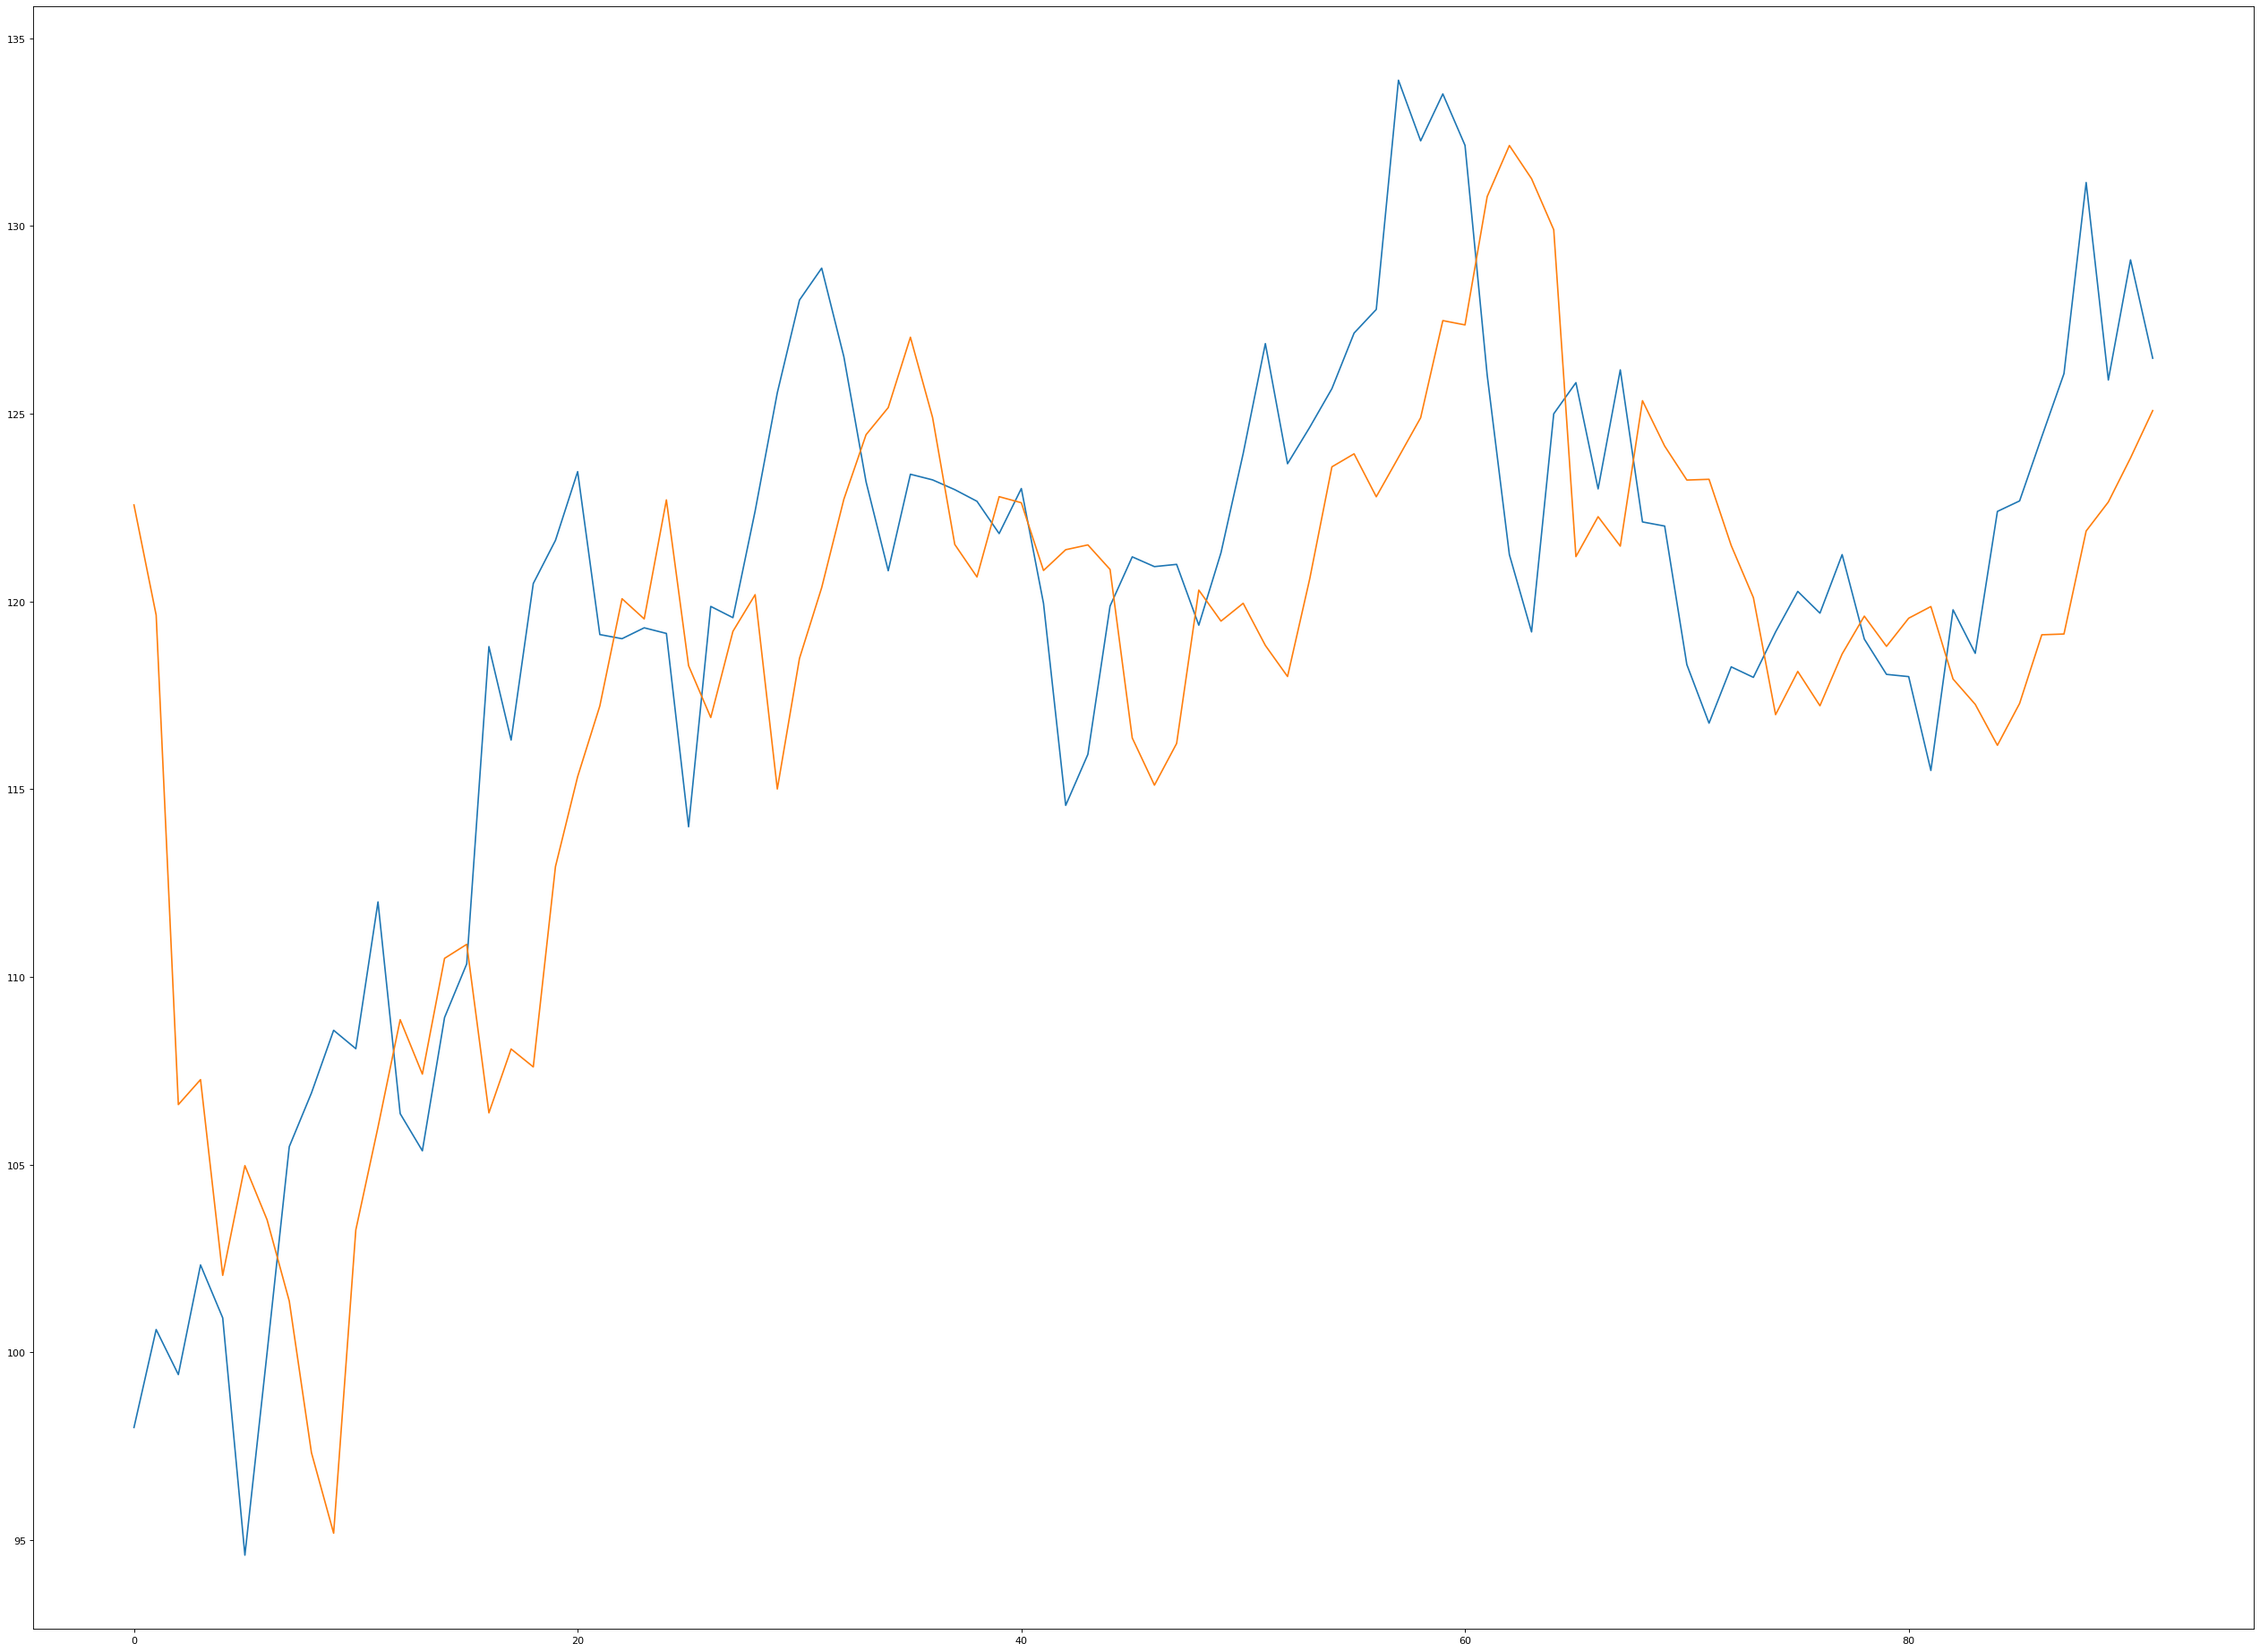

In [35]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), true_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()

##### Last 16 days + prediction of last 8 days

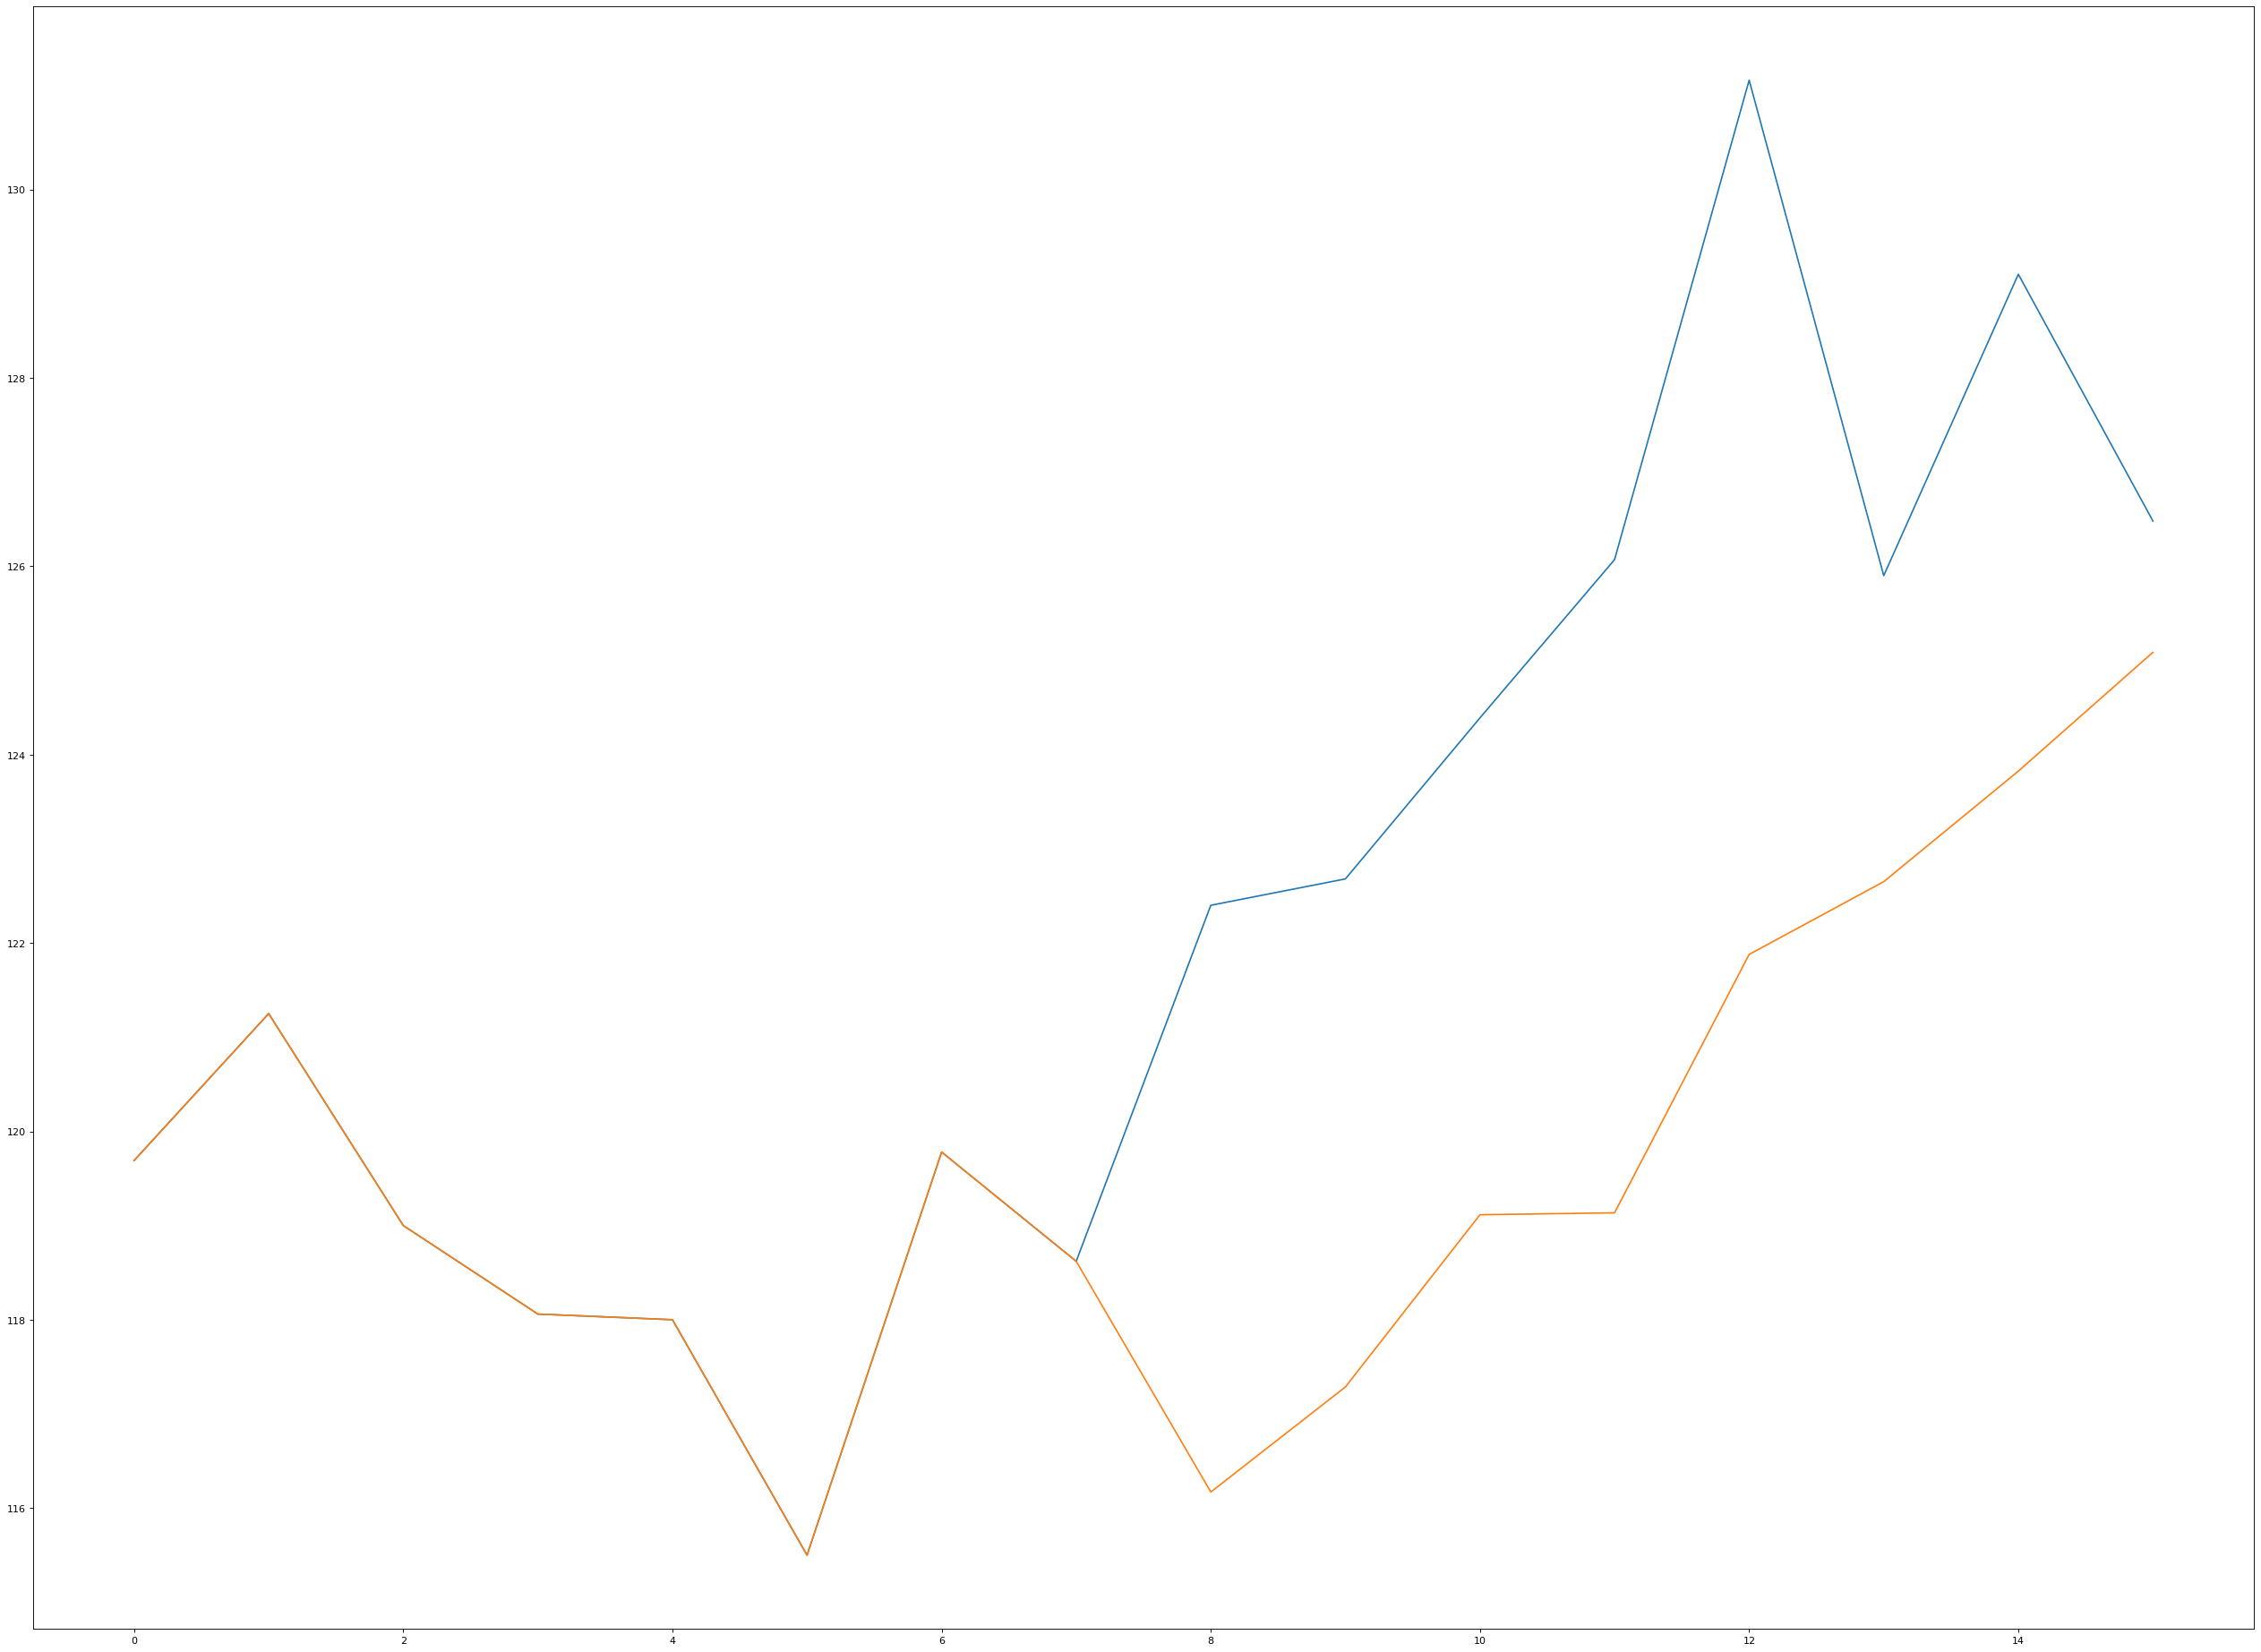

In [38]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(16), true_y_test[-16:])
plt.plot(range(16), np.append(true_y_test[-16:-8], predicted_y_test[-8:]))
plt.show()